In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf


# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

import keras_tuner as kt
import sys

2022-03-03 06:11:07.109410: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 06:11:07.940172: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-03 06:11:07.941009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-03 06:11:07.960754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-03 06:11:07.960780: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 06:11:07.962322: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

Define functions

In [2]:
def yield_and_error(df):
    '''
    input: 
    df  : dataframe
    
    output:
    yield (significance, error)
    '''
    Y  = -1
    dY = -1
    Y  = sum(df.wgt)
    dY = np.sqrt(sum(df.wgt**2))
    # return tuple
    return Y, dY


def significance_and_error(S, dS, B, dB):
    '''
    input: 
    S  : signal
    dS : signal error
    B  : background
    dB : background error
    
    output:
    tuple (significance, error)
    '''
    # FAKE SIGNIFICANCE
#     significance = S/np.sqrt(B)
#     error        = np.sqrt( 1/B*(dS**2) + (S**2)/(4*B**3)*(dB**2) )
#     return significance, error
    
    # REAL SIGNIFICANCE
    # if a quantity is negative, return 0
    if (S<=0 or B<=0):
        return 0, 0
#     S = np.abs(S)
#     B = np.abs(B)
    # calculate the significance and its error
    significance = np.sqrt( 2*((S + B)*np.log(1 + S/B) - S) )
    dSignifdS    = np.log(1 + S/B)/significance
    dSignifdB    = ( np.log(1 + S/B) - S/B )/significance
    error        = np.sqrt( (dSignifdS*dS)**2 + (dSignifdB*dB)**2 )
    # return tuple
    return significance, error


def add_in_quadrature_3( XdX, YdY, ZdZ ):
    '''
    input: 
    XdX : tuple (significance, error)
    YdY : tuple (significance, error)
    ZdZ : tuple (significance, error)
    
    output:
    tuple (significance, error) added in quadrature
    '''
    # unpack the significances
    x, dx = XdX
    y, dy = YdY
    z, dz = ZdZ
    # calculate the addition in quadrature and its error
    quadrature_sum   = np.sqrt(x**2 + y**2 + z**2)
    A                = (x**2)*(dx**2) + (y**2)*(dy**2) + (z**2)*(dz**2)
    B                = (x**2) + (y**2) + (z**2)
    if (quadrature_sum==0):
        return 0, 0
    quadrature_error = np.sqrt( A / B )
    # return tuple
    return quadrature_sum, quadrature_error


def add_in_quadrature_n( my_inputs ):
    '''
    input: 
    a list of the type [XdX, YdY, ZdZ, etc.]
    where
    XdX : tuple (significance, error)
    YdY : tuple (significance, error)
    ZdZ : tuple (significance, error)
    
    output:
    tuple (significance, error) added in quadrature
    '''
    # unpack the significances
    values = np.array([])
    errors = np.array([])
    for i in range(len(my_inputs)):
        x, dx = my_inputs[i]
        values = np.append(values, x)
        errors = np.append(errors, dx)
    # calculate the addition in quadrature and its error
    quadrature_sum = np.sqrt(sum(values**2))
    
    A = sum((values**2)*(errors**2))
    B = sum(values**2)
    
#     quadrature_sum   = np.sqrt(x**2 + y**2 + z**2)
#     A                = (x**2)*(dx**2) + (y**2)*(dy**2) + (z**2)*(dz**2)
#     B                = (x**2) + (y**2) + (z**2)
    if (quadrature_sum==0):
        return 0, 0
    quadrature_error = np.sqrt( A / B )
    # return tuple
    return quadrature_sum, quadrature_error


def total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        m_list.append(significance_and_error(S, dS, B, dB))
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    return significance, error

def print_total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        print("--- S = {:.2f} ± {:.2f} ".format(S, dS))
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        print("--- B = {:.2f} ± {:.2f} ".format(B, dB))
        m_list.append(significance_and_error(S, dS, B, dB))
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    print("SF-inZ significance = {:.2f} ± {:.2f} ".format(m_list[0][0], m_list[0][1]))
    print("SF-noZ significance = {:.2f} ± {:.2f} ".format(m_list[1][0], m_list[1][1]))
    print("DF significance     = {:.2f} ± {:.2f} ".format(m_list[2][0], m_list[2][1]))
    print("Total significance  = {:.2f} ± {:.2f} ".format(significance, error))


test

In [3]:
add_in_quadrature_3((1.2,0.1),(1.6,0.2),(2.4,0.2))

(3.1240998703626617, 0.1886101017756029)

In [4]:
add_in_quadrature_n([(1.2,0.1),(1.6,0.2),(2.4,0.2),(3.4,0.1)])

(4.6173585522460785, 0.14733403229794106)

# Real ML starts here

In [5]:
this_channel = '20220301_ELReLMIs54_MUReLMIs31_btag77'

sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/' + this_channel + '_VVZ_RD.arrow')
sig = sig[sig.SR == 1]
sig['is_signal'] = True
sig = sig.reset_index(drop=True)

bg = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/' + this_channel + '_FULLBG_RD.arrow')
bg = bg[bg.SR == 1]
bg['is_signal'] = False
bg = bg.reset_index(drop=True)

name = 'trained_in_SR1'

In [6]:
print(len(sig), len(bg))
print(sum(sig.wgt), sum(bg.wgt))

11875 206650
5.35032569978533 311.4585960363611


In [7]:
print_total_significance_and_error(sig, bg)

--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- S = 5.35 ± 0.08 
--- B = 311.46 ± 2.16 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
SF-inZ significance = 0.00 ± 0.00 
SF-noZ significance = 0.30 ± 0.00 
DF significance     = 0.00 ± 0.00 
Total significance  = 0.30 ± 0.00 


In [8]:
sig.columns

Index(['index', 'Wlep1_phi', 'jet_eta_3', 'jet_btagCont_2', 'Zlep1_phi',
       'Wlep1_ambiguous', 'leptonic_HT', 'Zlep2_pt', 'jet_m_2', 'jet_pt_2',
       'lep4_ambiguous', 'METSig', 'jet_eta_4', 'jet_m_3', 'Zlep2_phi', 'MET',
       'other_mass', 'jet_m_4', 'Wlep2_pid', 'jet_eta_1', 'Wlep1_dphi',
       'Zlep1_pt', 'eta_3', 'eta_4', 'jet_pt_4', 'METPhi', 'wgt', 'jet_eta_2',
       'phi_4', 'v_j_btag70', 'phi_1', 'jet_btagCont_4', 'jet_phi_2',
       'jet_phi_3', 'Wlep2_ambiguous', 'Zlep1_dphi', 'Zlep1_pid', 'lep4_pid',
       'mass_4l', 'Zlep2_pid', 'pt_4l', 'lep1_ambiguous', 'SR', 'Wlep1_pt',
       'lep2_pid', 'Wlep1_pid', 'v_j_btag77', 'Wlep2_phi', 'chisq',
       'Zlep1_ambiguous', 'jet_pt_3', 'jet_m_1', 'eta_1', 'v_j_btag85',
       'jet_btagCont_3', 'total_HT', 'Zlep2_ambiguous', 'lep3_ambiguous',
       'Zlep1_eta', 'Zlep2_dphi', 'lep3_pid', 'jet_btagCont_1', 'HT', 'pt_2',
       'pt_4', 'pt_3', 'Wlep1_eta', 'Wlep2_dphi', 'phi_3', 'Zlep2_eta',
       'jet_pt_1', 'pt_1', 'jet_p

In [9]:

lep_dphi_cols = ['Zlep1_pt', 'Zlep1_eta', 'Zlep1_dphi', 
                 'Zlep2_pt', 'Zlep2_eta', 'Zlep2_dphi', 
                 'Wlep1_pt', 'Wlep1_eta', 'Wlep1_dphi', 
                 'Wlep2_pt', 'Wlep2_eta', 'Wlep2_dphi', 
                 'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid','Wlep2_pid', 
                 'pt_1', 'pt_2', 'pt_4', 'pt_3', 
                 'Zcand_mass', 'other_mass', 'mass_4l', 'pt_4l',
                 'leptonic_HT', 'HT',  'total_HT',   
                 'MET', 'METSig', 
                 'Njet',
                 'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4',
                 'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4',
                 'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4',]

                 
# lep_dphi_cols = ['Zlep1_pt', 'Zlep1_eta' 'Zlep1_dphi', 
#                  'Zlep2_pt', 'Zlep2_eta' 'Zlep2_dphi', 
#                  'Wlep1_pt', 'Wlep1_eta' 'Wlep1_dphi', 
#                  'Wlep2_pt', 'Wlep2_eta' 'Wlep2_dphi', 
#                  'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid','Wlep2_pid', 
#                  'pt_1', 'pt_2', 'pt_4', 'pt_3', 
#                  'Zcand_mass', 'other_mass', 'mass_4l', 'pt_4l',
#                  'leptonic_HT', 'HT',  'total_HT',   
#                  'MET', 'METSig', 
#                  'Njet',
#                  'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4',
#                  'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4',
#                  'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4',
#                  'jet_btagCont_1','jet_btagCont_2','jet_btagCont_3','jet_btagCont_4']

X = pd.concat([sig[lep_dphi_cols], bg[lep_dphi_cols]], ignore_index=True)

In [10]:
# Normalize inputs for NN training
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[lep_dphi_cols] = min_max_scaler.transform(df[lep_dphi_cols])

In [11]:
sig['dummy_wgt'] = 1
bg['dummy_wgt']  = 1

In [12]:
# Split train and test data

# sig_train, sig_test = train_test_split(sig[lep_dphi_cols + ['wgt'] + ['SR']], train_size=0.5)
# bg_train, bg_test = train_test_split(bg[lep_dphi_cols + ['wgt'] + ['SR']], train_size=0.5)
sig_train, sig_test = train_test_split(sig[lep_dphi_cols + ['dummy_wgt'] + ['wgt'] + ['SR']], train_size=0.5)
bg_train,  bg_test  = train_test_split( bg[lep_dphi_cols + ['dummy_wgt'] + ['wgt'] + ['SR']], train_size=0.5)

n_sig = len(sig_train) # should be weighted?
n_bg = len(bg_train)

# weighted
n_sig = sum(sig_train['wgt']) 
n_bg = sum(bg_train['wgt'])

x_train = pd.concat([sig_train[lep_dphi_cols], bg_train[lep_dphi_cols]])
y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))]) # [1,1,...,0,0,...]
wgt_train = np.concatenate([sig_train['wgt'], bg_train['wgt']])
# Scaling the weight and dummy weights:
w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                    (n_sig + n_bg) / n_bg  *  bg_train['wgt']]))
dummy_w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['dummy_wgt'], 
                                          (n_sig + n_bg) / n_bg  *  bg_train['dummy_wgt']]))
SR_train = np.concatenate([sig_train['SR'], bg_train['SR']])
# sklearn.utils import shuffle
x_train, y_train, wgt_train, w_train, dummy_w_train, SR_train = shuffle(x_train, y_train, wgt_train, w_train, dummy_w_train, SR_train)


n_sig = len(sig_test) 
n_bg = len(bg_test)

# weighted
n_sig = sum(sig_test['wgt']) 
n_bg = sum(bg_test['wgt'])


x_test = pd.concat([sig_test[lep_dphi_cols], bg_test[lep_dphi_cols]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])  # [1,1,...,0,0,...]
wgt_test = np.concatenate([sig_test['wgt'], bg_test['wgt']])
# Scaling the weight and dummy weights:
w_test = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_test['wgt'], 
                                   (n_sig + n_bg) / n_bg  * bg_test['wgt']]))
dummy_w_test = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_test['dummy_wgt'], 
                                         (n_sig + n_bg) / n_bg  *  bg_test['dummy_wgt']]))
SR_test = np.concatenate([sig_test['SR'], bg_test['SR']])


In [13]:
print(len(sig_train), len(bg_train), len(y_train), len(w_train))
print("Training sample")
print_total_significance_and_error(sig_train, bg_train)

5937 103325 109262 109262
Training sample
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- S = 2.63 ± 0.06 
--- B = 155.89 ± 1.79 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
SF-inZ significance = 0.00 ± 0.00 
SF-noZ significance = 0.21 ± 0.00 
DF significance     = 0.00 ± 0.00 
Total significance  = 0.21 ± 0.00 


In [14]:
print(len(sig_test), len(bg_test), len(y_test), len(w_test))
print("Eval sample")
print_total_significance_and_error(sig_test, bg_test)

5938 103325 109263 109263
Eval sample
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- S = 2.72 ± 0.06 
--- B = 155.57 ± 1.22 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
SF-inZ significance = 0.00 ± 0.00 
SF-noZ significance = 0.22 ± 0.00 
DF significance     = 0.00 ± 0.00 
Total significance  = 0.22 ± 0.00 


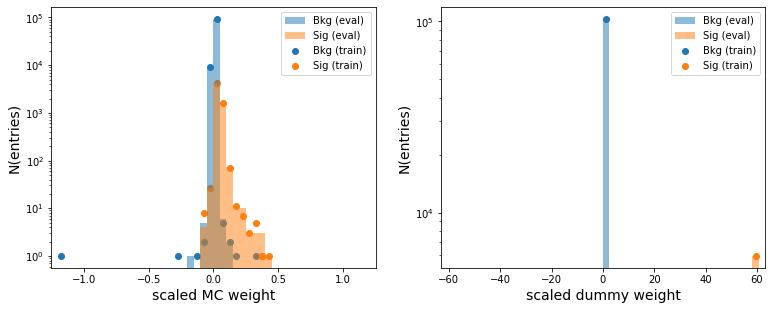

In [15]:
plt.figure(figsize=[2*6.4,1*4.8])

b = 50
ax = plt.subplot(1, 2, 1)
m = 1.05*np.max([np.max(abs(w_train)), np.max(abs(w_test))])
# plot test
_, b, _ = plt.hist(w_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')
_, b, _ = plt.hist(w_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)')
# plot train
bin_centers = (b[:-1]+b[1:])/2
w_train_bg  = np.histogram(w_train[y_train == 0], bins=b)[0]
w_train_sig = np.histogram(w_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, w_train_bg,  label='Bkg (train)')
plt.scatter(bin_centers, w_train_sig, label='Sig (train)')
plt.xlim([-m,m])
plt.yscale('log')
plt.legend()
plt.xlabel('scaled MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

b = 50
ax = plt.subplot(1, 2, 2)
m = 1.05*np.max([np.max(abs(dummy_w_train)), np.max(abs(dummy_w_test))])
# plot test
_, b, _ = plt.hist(dummy_w_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')
_, b, _ = plt.hist(dummy_w_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)')
bin_centers = (b[:-1]+b[1:])/2
# plot train
dummy_w_train_bg  = np.histogram(dummy_w_train[y_train == 0], bins=b)[0]
dummy_w_train_sig = np.histogram(dummy_w_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, dummy_w_train_bg,  label='Bkg (train)')
plt.scatter(bin_centers, dummy_w_train_sig, label='Sig (train)')
plt.xlim([-m,m])
plt.yscale('log')
plt.legend()
plt.xlabel('scaled dummy weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

plt.savefig('plots/scaled_weights_{}.pdf'.format(name))

plt.show()

Zoomed-in version of the normal MC weight, to see the substructure:

0.0076239560211240195
0.0001524791204224804


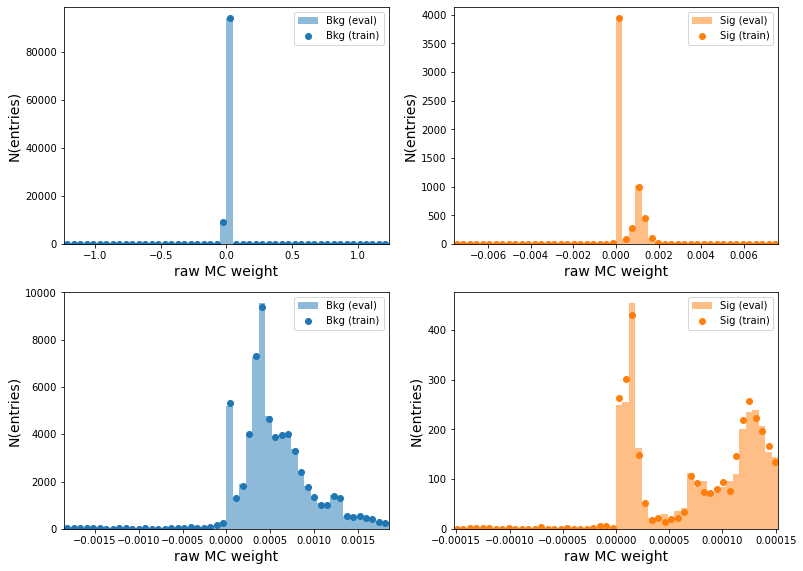

In [16]:
fig = plt.figure(figsize=[2*6.4,2*4.8])

b = 50
ax = plt.subplot(2, 2, 1)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==0])), np.max(abs(wgt_test[y_test==0]))])
# plot test
_, b, _ = plt.hist(wgt_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_bg  = np.histogram(wgt_train[y_train == 0], bins=b)[0]
plt.scatter(bin_centers, wgt_train_bg,  label='Bkg (train)')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

b = 50
ax = plt.subplot(2, 2, 2)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==1])), np.max(abs(wgt_test[y_test==1]))])
print(m)
# plot test
_, b, _ = plt.hist(wgt_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)', color='C1')
# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_sig = np.histogram(wgt_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, wgt_train_sig, label='Sig (train)', color='C1')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)


b = 50
ax = plt.subplot(2, 2, 3)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==0])), np.max(abs(wgt_test[y_test==0]))])*0.0015
# plot test
_, b, _ = plt.hist(wgt_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_bg  = np.histogram(wgt_train[y_train == 0], bins=b)[0]
plt.scatter(bin_centers, wgt_train_bg,  label='Bkg (train)')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

b = 50
ax = plt.subplot(2, 2, 4)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==1])), np.max(abs(wgt_test[y_test==1]))])*0.02
print(m)
# plot test
_, b, _ = plt.hist(wgt_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)', color='C1')
# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_sig = np.histogram(wgt_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, wgt_train_sig, label='Sig (train)', color='C1')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

plt.savefig('plots/raw_weights_{}.pdf'.format(name))
plt.show()

# Fit ML classifier

In [17]:
use_mc_weights = True
# use_mc_weights = False

# Chop off the negative weights?

Train and evaluate!

In [18]:
# Fit ML classifier
EPOCHS = 10000
patience = 20
batch_size = 256
num_nodes = 64
dropout = 0.1
learn_rate = 1e-5

v_classifier = []
v_history = []

n_models = 10

x_test_results = x_test.copy()

for i in range(n_models):
    print("Running model", i)
    
    # Generate and fit model
    K.clear_session()

# Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    if (use_mc_weights):
        history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                                verbose=1, callbacks=[callback])
    else:
        history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                validation_data=(x_test, y_test, dummy_w_test), sample_weight=dummy_w_train, 
                                verbose=1, callbacks=[callback])
    
    v_classifier.append(classifier)
    v_history.append(history)
    
    x_test_results['pred_' + str(i)] = classifier.predict(x_test, batch_size=batch_size)

Running model 0


2022-03-03 06:11:15.656092: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 06:11:15.658140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-03 06:11:15.658202: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 06:11:15.658227: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-03 06:11:15.658236: I tensorflow/stream_executor/plat

Epoch 1/10000
  1/427 [..............................] - ETA: 3:39 - loss: 0.0015 - accuracy: 0.7461

2022-03-03 06:11:16.564464: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


427/427 [==============================] - 4s 7ms/step - loss: 0.0020 - accuracy: 0.7708 - val_loss: 0.0020 - val_accuracy: 0.8534
Epoch 2/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.7103 - val_loss: 0.0020 - val_accuracy: 0.7697
Epoch 3/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.6377 - val_loss: 0.0020 - val_accuracy: 0.6990
Epoch 4/10000
427/427 [==============================] - 2s 6ms/step - loss: 0.0020 - accuracy: 0.5871 - val_loss: 0.0020 - val_accuracy: 0.6360
Epoch 5/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.5498 - val_loss: 0.0020 - val_accuracy: 0.5914
Epoch 6/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.5313 - val_loss: 0.0020 - val_accuracy: 0.5553
Epoch 7/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.5034 - val_loss: 0.0020 - val_accuracy: 0.5177

427/427 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.6608 - val_loss: 0.0015 - val_accuracy: 0.7064
Epoch 114/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.6730 - val_loss: 0.0015 - val_accuracy: 0.7027
Epoch 115/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.6734 - val_loss: 0.0015 - val_accuracy: 0.6831
Epoch 116/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.6547 - val_loss: 0.0015 - val_accuracy: 0.7046
Epoch 117/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.6714 - val_loss: 0.0015 - val_accuracy: 0.7000
Epoch 118/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6723 - val_loss: 0.0015 - val_accuracy: 0.7065
Epoch 119/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.6755 - val_loss: 0.0015 - val_accu

Epoch 169/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6921 - val_loss: 0.0014 - val_accuracy: 0.7228
Epoch 170/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6909 - val_loss: 0.0014 - val_accuracy: 0.7208
Epoch 171/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6930 - val_loss: 0.0014 - val_accuracy: 0.7157
Epoch 172/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6929 - val_loss: 0.0014 - val_accuracy: 0.7041
Epoch 173/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6864 - val_loss: 0.0014 - val_accuracy: 0.7251
Epoch 174/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6965 - val_loss: 0.0014 - val_accuracy: 0.7233
Epoch 175/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6991 - val_loss: 0

Epoch 225/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7041 - val_loss: 0.0013 - val_accuracy: 0.7376
Epoch 226/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7109 - val_loss: 0.0013 - val_accuracy: 0.7431
Epoch 227/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7168 - val_loss: 0.0013 - val_accuracy: 0.7296
Epoch 228/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7060 - val_loss: 0.0013 - val_accuracy: 0.7329
Epoch 229/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7079 - val_loss: 0.0013 - val_accuracy: 0.7451
Epoch 230/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7173 - val_loss: 0.0013 - val_accuracy: 0.7309
Epoch 231/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7038 - val_loss: 0

Epoch 281/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7217 - val_loss: 0.0012 - val_accuracy: 0.7523
Epoch 282/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7242 - val_loss: 0.0012 - val_accuracy: 0.7465
Epoch 283/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7198 - val_loss: 0.0012 - val_accuracy: 0.7504
Epoch 284/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7170 - val_loss: 0.0012 - val_accuracy: 0.7538
Epoch 285/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7268 - val_loss: 0.0012 - val_accuracy: 0.7503
Epoch 286/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7289 - val_loss: 0.0012 - val_accuracy: 0.7520
Epoch 287/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7317 - val_loss: 0

Epoch 337/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7326 - val_loss: 0.0012 - val_accuracy: 0.7668
Epoch 338/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7405 - val_loss: 0.0012 - val_accuracy: 0.7626
Epoch 339/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7396 - val_loss: 0.0012 - val_accuracy: 0.7706
Epoch 340/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7409 - val_loss: 0.0012 - val_accuracy: 0.7634
Epoch 341/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7393 - val_loss: 0.0012 - val_accuracy: 0.7568
Epoch 342/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7376 - val_loss: 0.0012 - val_accuracy: 0.7696
Epoch 343/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7487 - val_loss: 0

Epoch 393/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7497 - val_loss: 0.0011 - val_accuracy: 0.7708
Epoch 394/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7495 - val_loss: 0.0011 - val_accuracy: 0.7738
Epoch 395/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7542 - val_loss: 0.0011 - val_accuracy: 0.7685
Epoch 396/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7524 - val_loss: 0.0011 - val_accuracy: 0.7679
Epoch 397/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7538 - val_loss: 0.0011 - val_accuracy: 0.7739
Epoch 398/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7564 - val_loss: 0.0011 - val_accuracy: 0.7698
Epoch 399/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7454 - val_loss: 0

Epoch 449/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7585 - val_loss: 0.0011 - val_accuracy: 0.7739
Epoch 450/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7521 - val_loss: 0.0011 - val_accuracy: 0.7775
Epoch 451/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7601 - val_loss: 0.0011 - val_accuracy: 0.7774
Epoch 452/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7602 - val_loss: 0.0011 - val_accuracy: 0.7751
Epoch 453/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7628 - val_loss: 0.0011 - val_accuracy: 0.7704
Epoch 454/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7574 - val_loss: 0.0011 - val_accuracy: 0.7706
Epoch 455/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7496 - val_loss: 0

Epoch 505/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7689 - val_loss: 0.0011 - val_accuracy: 0.7831
Epoch 506/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7638 - val_loss: 0.0011 - val_accuracy: 0.7834
Epoch 507/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7685 - val_loss: 0.0011 - val_accuracy: 0.7752
Epoch 508/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7638 - val_loss: 0.0011 - val_accuracy: 0.7758
Epoch 509/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7641 - val_loss: 0.0011 - val_accuracy: 0.7772
Epoch 510/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7667 - val_loss: 0.0011 - val_accuracy: 0.7793
Epoch 511/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7673 - val_loss: 0

Epoch 561/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7691 - val_loss: 0.0011 - val_accuracy: 0.7826
Epoch 562/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7696 - val_loss: 0.0011 - val_accuracy: 0.7855
Epoch 563/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7686 - val_loss: 0.0011 - val_accuracy: 0.7799
Epoch 564/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7665 - val_loss: 0.0011 - val_accuracy: 0.7855
Epoch 565/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7709 - val_loss: 0.0011 - val_accuracy: 0.7846
Epoch 566/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7680 - val_loss: 0.0011 - val_accuracy: 0.7875
Epoch 567/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7789 - val_loss: 0

Epoch 672/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7778 - val_loss: 0.0011 - val_accuracy: 0.7832
Epoch 673/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7726 - val_loss: 0.0011 - val_accuracy: 0.7877
Epoch 674/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7759 - val_loss: 0.0011 - val_accuracy: 0.7865
Epoch 675/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7722 - val_loss: 0.0011 - val_accuracy: 0.7860
Epoch 676/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7781 - val_loss: 0.0011 - val_accuracy: 0.7824
Epoch 677/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0010 - accuracy: 0.7728 - val_loss: 0.0011 - val_accuracy: 0.7831
Epoch 678/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7730 - val_loss: 0

Epoch 6/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0020 - accuracy: 0.4443 - val_loss: 0.0020 - val_accuracy: 0.3776
Epoch 7/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0020 - accuracy: 0.4342 - val_loss: 0.0020 - val_accuracy: 0.3878
Epoch 8/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0020 - accuracy: 0.4223 - val_loss: 0.0020 - val_accuracy: 0.4024
Epoch 9/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0020 - accuracy: 0.4353 - val_loss: 0.0019 - val_accuracy: 0.4060
Epoch 10/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0020 - accuracy: 0.4256 - val_loss: 0.0019 - val_accuracy: 0.4225
Epoch 11/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0019 - accuracy: 0.4639 - val_loss: 0.0019 - val_accuracy: 0.4195
Epoch 12/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0020 - accuracy: 0.4466 - val_loss: 0.0019 - val

427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6736 - val_loss: 0.0015 - val_accuracy: 0.6959
Epoch 119/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.6632 - val_loss: 0.0015 - val_accuracy: 0.7064
Epoch 120/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6751 - val_loss: 0.0015 - val_accuracy: 0.7000
Epoch 121/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.6625 - val_loss: 0.0015 - val_accuracy: 0.7098
Epoch 122/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6759 - val_loss: 0.0015 - val_accuracy: 0.6996
Epoch 123/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6713 - val_loss: 0.0015 - val_accuracy: 0.6988
Epoch 124/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.6706 - val_loss: 0.0015 - val_accu

Epoch 174/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6878 - val_loss: 0.0014 - val_accuracy: 0.7133
Epoch 175/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6818 - val_loss: 0.0014 - val_accuracy: 0.7232
Epoch 176/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6892 - val_loss: 0.0014 - val_accuracy: 0.7161
Epoch 177/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6911 - val_loss: 0.0014 - val_accuracy: 0.7150
Epoch 178/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6916 - val_loss: 0.0014 - val_accuracy: 0.7235
Epoch 179/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6968 - val_loss: 0.0014 - val_accuracy: 0.7136
Epoch 180/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6857 - val_loss: 0

Epoch 230/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7088 - val_loss: 0.0013 - val_accuracy: 0.7431
Epoch 231/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7119 - val_loss: 0.0013 - val_accuracy: 0.7414
Epoch 232/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7119 - val_loss: 0.0013 - val_accuracy: 0.7347
Epoch 233/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7076 - val_loss: 0.0013 - val_accuracy: 0.7397
Epoch 234/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7112 - val_loss: 0.0013 - val_accuracy: 0.7434
Epoch 235/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7158 - val_loss: 0.0013 - val_accuracy: 0.7377
Epoch 236/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.7039 - val_loss: 0

Epoch 286/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7205 - val_loss: 0.0012 - val_accuracy: 0.7681
Epoch 287/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7351 - val_loss: 0.0012 - val_accuracy: 0.7587
Epoch 288/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7269 - val_loss: 0.0012 - val_accuracy: 0.7570
Epoch 289/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7219 - val_loss: 0.0012 - val_accuracy: 0.7605
Epoch 290/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7281 - val_loss: 0.0012 - val_accuracy: 0.7665
Epoch 291/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7362 - val_loss: 0.0012 - val_accuracy: 0.7517
Epoch 292/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7259 - val_loss: 0

Epoch 342/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7431 - val_loss: 0.0012 - val_accuracy: 0.7671
Epoch 343/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7300 - val_loss: 0.0012 - val_accuracy: 0.7784
Epoch 344/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7411 - val_loss: 0.0012 - val_accuracy: 0.7755
Epoch 345/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7458 - val_loss: 0.0012 - val_accuracy: 0.7647
Epoch 346/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7333 - val_loss: 0.0012 - val_accuracy: 0.7689
Epoch 347/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7341 - val_loss: 0.0012 - val_accuracy: 0.7706
Epoch 348/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7385 - val_loss: 0

Epoch 398/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7481 - val_loss: 0.0011 - val_accuracy: 0.7806
Epoch 399/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7485 - val_loss: 0.0011 - val_accuracy: 0.7884
Epoch 400/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7581 - val_loss: 0.0011 - val_accuracy: 0.7767
Epoch 401/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7522 - val_loss: 0.0011 - val_accuracy: 0.7727
Epoch 402/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7470 - val_loss: 0.0011 - val_accuracy: 0.7874
Epoch 403/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7558 - val_loss: 0.0011 - val_accuracy: 0.7748
Epoch 404/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7442 - val_loss: 0

Epoch 454/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7567 - val_loss: 0.0011 - val_accuracy: 0.7826
Epoch 455/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7561 - val_loss: 0.0011 - val_accuracy: 0.7858
Epoch 456/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7608 - val_loss: 0.0011 - val_accuracy: 0.7816
Epoch 457/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7487 - val_loss: 0.0011 - val_accuracy: 0.7852
Epoch 458/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7570 - val_loss: 0.0011 - val_accuracy: 0.7849
Epoch 459/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7489 - val_loss: 0.0011 - val_accuracy: 0.7933
Epoch 460/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7652 - val_loss: 0

Epoch 510/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7669 - val_loss: 0.0011 - val_accuracy: 0.7912
Epoch 511/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7636 - val_loss: 0.0011 - val_accuracy: 0.7909
Epoch 512/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7673 - val_loss: 0.0011 - val_accuracy: 0.7859
Epoch 513/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7569 - val_loss: 0.0011 - val_accuracy: 0.7907
Epoch 514/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7629 - val_loss: 0.0011 - val_accuracy: 0.7895
Epoch 515/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7674 - val_loss: 0.0011 - val_accuracy: 0.7809
Epoch 516/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7546 - val_loss: 0

Epoch 566/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7630 - val_loss: 0.0011 - val_accuracy: 0.8015
Epoch 567/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7693 - val_loss: 0.0011 - val_accuracy: 0.7895
Epoch 568/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0010 - accuracy: 0.7644 - val_loss: 0.0011 - val_accuracy: 0.7855
Epoch 569/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7676 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 570/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7649 - val_loss: 0.0011 - val_accuracy: 0.8004
Epoch 571/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7759 - val_loss: 0.0011 - val_accuracy: 0.7953
Epoch 572/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7726 - val_loss: 0

Epoch 622/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7709 - val_loss: 0.0011 - val_accuracy: 0.8008
Epoch 623/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7681 - val_loss: 0.0011 - val_accuracy: 0.8001
Epoch 624/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7799 - val_loss: 0.0011 - val_accuracy: 0.7934
Epoch 625/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7673 - val_loss: 0.0011 - val_accuracy: 0.7958
Epoch 626/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0010 - accuracy: 0.7696 - val_loss: 0.0011 - val_accuracy: 0.7966
Epoch 627/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7720 - val_loss: 0.0011 - val_accuracy: 0.7948
Epoch 628/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7714 - val_loss: 0

427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7696 - val_loss: 0.0011 - val_accuracy: 0.7951
Epoch 733/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7771 - val_loss: 0.0011 - val_accuracy: 0.7999
Epoch 734/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7773 - val_loss: 0.0011 - val_accuracy: 0.8051
Epoch 735/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7819 - val_loss: 0.0011 - val_accuracy: 0.7936
Epoch 736/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0010 - accuracy: 0.7738 - val_loss: 0.0011 - val_accuracy: 0.7970
Epoch 737/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7741 - val_loss: 0.0011 - val_accuracy: 0.8011
Epoch 738/10000
427/427 [==============================] - 3s 7ms/step - loss: 9.4077e-04 - accuracy: 0.7812 - val_loss: 0.0011 - val_

Epoch 788/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0010 - accuracy: 0.7812 - val_loss: 0.0011 - val_accuracy: 0.8017
Epoch 789/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7843 - val_loss: 0.0011 - val_accuracy: 0.7926
Epoch 790/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0010 - accuracy: 0.7779 - val_loss: 0.0011 - val_accuracy: 0.7957
Epoch 791/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0010 - accuracy: 0.7743 - val_loss: 0.0011 - val_accuracy: 0.8047
Epoch 792/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7827 - val_loss: 0.0011 - val_accuracy: 0.8005
Epoch 793/10000
427/427 [==============================] - 3s 7ms/step - loss: 9.8165e-04 - accuracy: 0.7796 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 794/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7787 - val_los

Epoch 29/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0019 - accuracy: 0.5307 - val_loss: 0.0019 - val_accuracy: 0.5032
Epoch 30/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0019 - accuracy: 0.5319 - val_loss: 0.0018 - val_accuracy: 0.5033
Epoch 31/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0019 - accuracy: 0.5280 - val_loss: 0.0018 - val_accuracy: 0.5038
Epoch 32/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0019 - accuracy: 0.5242 - val_loss: 0.0018 - val_accuracy: 0.5107
Epoch 33/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0019 - accuracy: 0.5319 - val_loss: 0.0018 - val_accuracy: 0.5104
Epoch 34/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0018 - accuracy: 0.5381 - val_loss: 0.0018 - val_accuracy: 0.5123
Epoch 35/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0018 - accuracy: 0.5386 - val_loss: 0.0018 -

Epoch 141/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6805 - val_loss: 0.0014 - val_accuracy: 0.7057
Epoch 142/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6930 - val_loss: 0.0014 - val_accuracy: 0.6888
Epoch 143/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6829 - val_loss: 0.0014 - val_accuracy: 0.6969
Epoch 144/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6796 - val_loss: 0.0014 - val_accuracy: 0.6950
Epoch 145/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6855 - val_loss: 0.0014 - val_accuracy: 0.6957
Epoch 146/10000
427/427 [==============================] - 2s 6ms/step - loss: 0.0015 - accuracy: 0.6818 - val_loss: 0.0014 - val_accuracy: 0.6997
Epoch 147/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6791 - val_loss: 0

Epoch 197/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7013 - val_loss: 0.0013 - val_accuracy: 0.7068
Epoch 198/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6924 - val_loss: 0.0013 - val_accuracy: 0.7190
Epoch 199/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7067 - val_loss: 0.0013 - val_accuracy: 0.7042
Epoch 200/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.6980 - val_loss: 0.0013 - val_accuracy: 0.7165
Epoch 201/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6953 - val_loss: 0.0013 - val_accuracy: 0.7268
Epoch 202/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7070 - val_loss: 0.0013 - val_accuracy: 0.7154
Epoch 203/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6997 - val_loss: 0

Epoch 253/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7164 - val_loss: 0.0012 - val_accuracy: 0.7374
Epoch 254/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7245 - val_loss: 0.0012 - val_accuracy: 0.7310
Epoch 255/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7136 - val_loss: 0.0012 - val_accuracy: 0.7412
Epoch 256/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7254 - val_loss: 0.0012 - val_accuracy: 0.7262
Epoch 257/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7090 - val_loss: 0.0012 - val_accuracy: 0.7463
Epoch 258/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7276 - val_loss: 0.0012 - val_accuracy: 0.7335
Epoch 259/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7238 - val_loss: 0

Epoch 309/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7331 - val_loss: 0.0012 - val_accuracy: 0.7464
Epoch 310/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7344 - val_loss: 0.0012 - val_accuracy: 0.7400
Epoch 311/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7325 - val_loss: 0.0012 - val_accuracy: 0.7494
Epoch 312/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7335 - val_loss: 0.0012 - val_accuracy: 0.7564
Epoch 313/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7322 - val_loss: 0.0012 - val_accuracy: 0.7492
Epoch 314/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7374 - val_loss: 0.0012 - val_accuracy: 0.7414
Epoch 315/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7340 - val_loss: 0

Epoch 365/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7430 - val_loss: 0.0011 - val_accuracy: 0.7569
Epoch 366/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7432 - val_loss: 0.0011 - val_accuracy: 0.7551
Epoch 367/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7362 - val_loss: 0.0011 - val_accuracy: 0.7652
Epoch 368/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7442 - val_loss: 0.0011 - val_accuracy: 0.7617
Epoch 369/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7491 - val_loss: 0.0011 - val_accuracy: 0.7585
Epoch 370/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7440 - val_loss: 0.0011 - val_accuracy: 0.7597
Epoch 371/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7474 - val_loss: 0

Epoch 421/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7559 - val_loss: 0.0011 - val_accuracy: 0.7625
Epoch 422/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7508 - val_loss: 0.0011 - val_accuracy: 0.7747
Epoch 423/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7509 - val_loss: 0.0011 - val_accuracy: 0.7710
Epoch 424/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7573 - val_loss: 0.0011 - val_accuracy: 0.7650
Epoch 425/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7475 - val_loss: 0.0011 - val_accuracy: 0.7753
Epoch 426/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7555 - val_loss: 0.0011 - val_accuracy: 0.7752
Epoch 427/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7572 - val_loss: 0

Epoch 477/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7590 - val_loss: 0.0011 - val_accuracy: 0.7734
Epoch 478/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7605 - val_loss: 0.0011 - val_accuracy: 0.7728
Epoch 479/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7608 - val_loss: 0.0011 - val_accuracy: 0.7690
Epoch 480/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7559 - val_loss: 0.0011 - val_accuracy: 0.7780
Epoch 481/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7604 - val_loss: 0.0011 - val_accuracy: 0.7782
Epoch 482/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7679 - val_loss: 0.0011 - val_accuracy: 0.7764
Epoch 483/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7638 - val_loss: 0

Epoch 533/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7655 - val_loss: 0.0011 - val_accuracy: 0.7771
Epoch 534/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7641 - val_loss: 0.0011 - val_accuracy: 0.7806
Epoch 535/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7680 - val_loss: 0.0011 - val_accuracy: 0.7818
Epoch 536/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7718 - val_loss: 0.0011 - val_accuracy: 0.7708
Epoch 537/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7652 - val_loss: 0.0011 - val_accuracy: 0.7727
Epoch 538/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7568 - val_loss: 0.0011 - val_accuracy: 0.7814
Epoch 539/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7652 - val_loss: 0

Epoch 589/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7697 - val_loss: 0.0011 - val_accuracy: 0.7840
Epoch 590/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7668 - val_loss: 0.0011 - val_accuracy: 0.7804
Epoch 591/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7675 - val_loss: 0.0011 - val_accuracy: 0.7821
Epoch 592/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7716 - val_loss: 0.0011 - val_accuracy: 0.7798
Epoch 593/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7660 - val_loss: 0.0011 - val_accuracy: 0.7797
Epoch 594/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7678 - val_loss: 0.0011 - val_accuracy: 0.7848
Epoch 595/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7720 - val_loss: 0

Epoch 645/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7668 - val_loss: 0.0011 - val_accuracy: 0.7852
Epoch 646/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7734 - val_loss: 0.0011 - val_accuracy: 0.7807
Epoch 647/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7684 - val_loss: 0.0011 - val_accuracy: 0.7847
Epoch 648/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7654 - val_loss: 0.0011 - val_accuracy: 0.7879
Epoch 649/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7749 - val_loss: 0.0011 - val_accuracy: 0.7801
Epoch 650/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7720 - val_loss: 0.0011 - val_accuracy: 0.7790
Epoch 651/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7660 - val_loss: 0

Epoch 756/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7754 - val_loss: 0.0011 - val_accuracy: 0.7880
Epoch 757/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7771 - val_loss: 0.0011 - val_accuracy: 0.7834
Epoch 758/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7728 - val_loss: 0.0011 - val_accuracy: 0.7873
Epoch 759/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7724 - val_loss: 0.0011 - val_accuracy: 0.7906
Epoch 760/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7816 - val_loss: 0.0011 - val_accuracy: 0.7828
Epoch 761/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7749 - val_loss: 0.0011 - val_accuracy: 0.7839
Epoch 762/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7758 - val_loss: 0

Epoch 35/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5292 - val_loss: 0.0018 - val_accuracy: 0.5408
Epoch 36/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5345 - val_loss: 0.0018 - val_accuracy: 0.5422
Epoch 37/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5461 - val_loss: 0.0018 - val_accuracy: 0.5410
Epoch 38/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5423 - val_loss: 0.0018 - val_accuracy: 0.5425
Epoch 39/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5429 - val_loss: 0.0018 - val_accuracy: 0.5483
Epoch 40/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5478 - val_loss: 0.0018 - val_accuracy: 0.5528
Epoch 41/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5454 - val_loss: 0.0018 -

Epoch 147/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6944 - val_loss: 0.0014 - val_accuracy: 0.7079
Epoch 148/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6842 - val_loss: 0.0014 - val_accuracy: 0.7086
Epoch 149/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6826 - val_loss: 0.0014 - val_accuracy: 0.7222
Epoch 150/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6922 - val_loss: 0.0014 - val_accuracy: 0.7184
Epoch 151/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6873 - val_loss: 0.0014 - val_accuracy: 0.7125
Epoch 152/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6901 - val_loss: 0.0014 - val_accuracy: 0.7179
Epoch 153/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6878 - val_loss: 0

Epoch 203/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7077 - val_loss: 0.0013 - val_accuracy: 0.7383
Epoch 204/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7071 - val_loss: 0.0013 - val_accuracy: 0.7443
Epoch 205/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7030 - val_loss: 0.0013 - val_accuracy: 0.7483
Epoch 206/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7153 - val_loss: 0.0013 - val_accuracy: 0.7341
Epoch 207/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7048 - val_loss: 0.0013 - val_accuracy: 0.7357
Epoch 208/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7101 - val_loss: 0.0013 - val_accuracy: 0.7344
Epoch 209/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7016 - val_loss: 0

Epoch 259/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7225 - val_loss: 0.0012 - val_accuracy: 0.7658
Epoch 260/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7244 - val_loss: 0.0012 - val_accuracy: 0.7559
Epoch 261/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7285 - val_loss: 0.0012 - val_accuracy: 0.7481
Epoch 262/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7229 - val_loss: 0.0012 - val_accuracy: 0.7549
Epoch 263/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7197 - val_loss: 0.0012 - val_accuracy: 0.7501
Epoch 264/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7217 - val_loss: 0.0012 - val_accuracy: 0.7543
Epoch 265/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7213 - val_loss: 0

Epoch 315/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7362 - val_loss: 0.0012 - val_accuracy: 0.7694
Epoch 316/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7366 - val_loss: 0.0012 - val_accuracy: 0.7647
Epoch 317/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7337 - val_loss: 0.0012 - val_accuracy: 0.7565
Epoch 318/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7239 - val_loss: 0.0012 - val_accuracy: 0.7667
Epoch 319/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7371 - val_loss: 0.0012 - val_accuracy: 0.7656
Epoch 320/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7364 - val_loss: 0.0012 - val_accuracy: 0.7742
Epoch 321/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7445 - val_loss: 0

Epoch 371/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7505 - val_loss: 0.0011 - val_accuracy: 0.7794
Epoch 372/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7487 - val_loss: 0.0011 - val_accuracy: 0.7678
Epoch 373/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7447 - val_loss: 0.0011 - val_accuracy: 0.7747
Epoch 374/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7486 - val_loss: 0.0011 - val_accuracy: 0.7760
Epoch 375/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7401 - val_loss: 0.0011 - val_accuracy: 0.7806
Epoch 376/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7474 - val_loss: 0.0011 - val_accuracy: 0.7702
Epoch 377/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7507 - val_loss: 0

Epoch 427/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7631 - val_loss: 0.0011 - val_accuracy: 0.7781
Epoch 428/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7533 - val_loss: 0.0011 - val_accuracy: 0.7870
Epoch 429/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7632 - val_loss: 0.0011 - val_accuracy: 0.7741
Epoch 430/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7445 - val_loss: 0.0011 - val_accuracy: 0.7802
Epoch 431/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7478 - val_loss: 0.0011 - val_accuracy: 0.7883
Epoch 432/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7561 - val_loss: 0.0011 - val_accuracy: 0.7840
Epoch 433/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7577 - val_loss: 0

Epoch 483/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7607 - val_loss: 0.0011 - val_accuracy: 0.7810
Epoch 484/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7577 - val_loss: 0.0011 - val_accuracy: 0.7873
Epoch 485/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7645 - val_loss: 0.0011 - val_accuracy: 0.7852
Epoch 486/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7586 - val_loss: 0.0011 - val_accuracy: 0.7917
Epoch 487/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7601 - val_loss: 0.0011 - val_accuracy: 0.7862
Epoch 488/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7563 - val_loss: 0.0011 - val_accuracy: 0.7930
Epoch 489/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7700 - val_loss: 0

Epoch 539/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7698 - val_loss: 0.0011 - val_accuracy: 0.7947
Epoch 540/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7658 - val_loss: 0.0011 - val_accuracy: 0.8011
Epoch 541/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7711 - val_loss: 0.0011 - val_accuracy: 0.7919
Epoch 542/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7703 - val_loss: 0.0011 - val_accuracy: 0.7851
Epoch 543/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7588 - val_loss: 0.0011 - val_accuracy: 0.7931
Epoch 544/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7643 - val_loss: 0.0011 - val_accuracy: 0.7981
Epoch 545/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7773 - val_loss: 0

Epoch 595/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7672 - val_loss: 0.0011 - val_accuracy: 0.8016
Epoch 596/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7786 - val_loss: 0.0011 - val_accuracy: 0.7927
Epoch 597/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7744 - val_loss: 0.0011 - val_accuracy: 0.7932
Epoch 598/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7731 - val_loss: 0.0011 - val_accuracy: 0.7929
Epoch 599/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7751 - val_loss: 0.0011 - val_accuracy: 0.7942
Epoch 600/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7697 - val_loss: 0.0011 - val_accuracy: 0.7961
Epoch 601/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7769 - val_loss: 0

Epoch 706/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7766 - val_loss: 0.0011 - val_accuracy: 0.7981
Epoch 707/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7753 - val_loss: 0.0011 - val_accuracy: 0.7913
Epoch 708/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7719 - val_loss: 0.0011 - val_accuracy: 0.7986
Epoch 709/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7841 - val_loss: 0.0011 - val_accuracy: 0.7861
Epoch 710/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7672 - val_loss: 0.0011 - val_accuracy: 0.8034
Epoch 711/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7817 - val_loss: 0.0011 - val_accuracy: 0.7981
Epoch 712/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7791 - val_loss: 0

Epoch 12/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5010 - val_loss: 0.0019 - val_accuracy: 0.4250
Epoch 13/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4778 - val_loss: 0.0019 - val_accuracy: 0.4440
Epoch 14/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4924 - val_loss: 0.0019 - val_accuracy: 0.4683
Epoch 15/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5127 - val_loss: 0.0019 - val_accuracy: 0.4624
Epoch 16/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5092 - val_loss: 0.0019 - val_accuracy: 0.4645
Epoch 17/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5109 - val_loss: 0.0019 - val_accuracy: 0.4660
Epoch 18/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4981 - val_loss: 0.0019 -

427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6888 - val_loss: 0.0014 - val_accuracy: 0.7193
Epoch 125/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6929 - val_loss: 0.0014 - val_accuracy: 0.7088
Epoch 126/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6788 - val_loss: 0.0014 - val_accuracy: 0.7177
Epoch 127/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6891 - val_loss: 0.0014 - val_accuracy: 0.7176
Epoch 128/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6945 - val_loss: 0.0014 - val_accuracy: 0.7199
Epoch 129/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6895 - val_loss: 0.0014 - val_accuracy: 0.7100
Epoch 130/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6889 - val_loss: 0.0014 - val_accu

Epoch 180/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7084 - val_loss: 0.0013 - val_accuracy: 0.7284
Epoch 181/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7021 - val_loss: 0.0013 - val_accuracy: 0.7299
Epoch 182/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7058 - val_loss: 0.0013 - val_accuracy: 0.7293
Epoch 183/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6999 - val_loss: 0.0013 - val_accuracy: 0.7404
Epoch 184/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7076 - val_loss: 0.0013 - val_accuracy: 0.7290
Epoch 185/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7106 - val_loss: 0.0013 - val_accuracy: 0.7311
Epoch 186/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7036 - val_loss: 0

Epoch 236/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7180 - val_loss: 0.0012 - val_accuracy: 0.7552
Epoch 237/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7271 - val_loss: 0.0012 - val_accuracy: 0.7450
Epoch 238/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7201 - val_loss: 0.0012 - val_accuracy: 0.7414
Epoch 239/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7206 - val_loss: 0.0012 - val_accuracy: 0.7430
Epoch 240/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7158 - val_loss: 0.0012 - val_accuracy: 0.7467
Epoch 241/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7146 - val_loss: 0.0012 - val_accuracy: 0.7496
Epoch 242/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7308 - val_loss: 0

Epoch 292/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7358 - val_loss: 0.0012 - val_accuracy: 0.7632
Epoch 293/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7348 - val_loss: 0.0012 - val_accuracy: 0.7569
Epoch 294/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7339 - val_loss: 0.0012 - val_accuracy: 0.7656
Epoch 295/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7403 - val_loss: 0.0012 - val_accuracy: 0.7601
Epoch 296/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7348 - val_loss: 0.0012 - val_accuracy: 0.7623
Epoch 297/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7388 - val_loss: 0.0012 - val_accuracy: 0.7721
Epoch 298/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7396 - val_loss: 0

Epoch 348/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7540 - val_loss: 0.0011 - val_accuracy: 0.7639
Epoch 349/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7391 - val_loss: 0.0011 - val_accuracy: 0.7757
Epoch 350/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7504 - val_loss: 0.0011 - val_accuracy: 0.7741
Epoch 351/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7477 - val_loss: 0.0011 - val_accuracy: 0.7776
Epoch 352/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7487 - val_loss: 0.0011 - val_accuracy: 0.7756
Epoch 353/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7519 - val_loss: 0.0011 - val_accuracy: 0.7701
Epoch 354/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7502 - val_loss: 0

Epoch 404/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7521 - val_loss: 0.0011 - val_accuracy: 0.7826
Epoch 405/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7570 - val_loss: 0.0011 - val_accuracy: 0.7844
Epoch 406/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7548 - val_loss: 0.0011 - val_accuracy: 0.7953
Epoch 407/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7630 - val_loss: 0.0011 - val_accuracy: 0.7772
Epoch 408/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7542 - val_loss: 0.0011 - val_accuracy: 0.7871
Epoch 409/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7545 - val_loss: 0.0011 - val_accuracy: 0.7905
Epoch 410/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7716 - val_loss: 0

Epoch 460/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7657 - val_loss: 0.0011 - val_accuracy: 0.7933
Epoch 461/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7677 - val_loss: 0.0011 - val_accuracy: 0.7902
Epoch 462/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7718 - val_loss: 0.0011 - val_accuracy: 0.7826
Epoch 463/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7617 - val_loss: 0.0011 - val_accuracy: 0.7808
Epoch 464/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7595 - val_loss: 0.0011 - val_accuracy: 0.7921
Epoch 465/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7685 - val_loss: 0.0011 - val_accuracy: 0.7765
Epoch 466/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7581 - val_loss: 0

Epoch 516/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7636 - val_loss: 0.0011 - val_accuracy: 0.7974
Epoch 517/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7728 - val_loss: 0.0011 - val_accuracy: 0.7915
Epoch 518/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7709 - val_loss: 0.0011 - val_accuracy: 0.7820
Epoch 519/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7604 - val_loss: 0.0011 - val_accuracy: 0.8014
Epoch 520/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7741 - val_loss: 0.0011 - val_accuracy: 0.7921
Epoch 521/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7693 - val_loss: 0.0011 - val_accuracy: 0.7882
Epoch 522/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7680 - val_loss: 0

Epoch 572/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7645 - val_loss: 0.0011 - val_accuracy: 0.7954
Epoch 573/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7680 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 574/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7763 - val_loss: 0.0011 - val_accuracy: 0.7917
Epoch 575/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7640 - val_loss: 0.0011 - val_accuracy: 0.7940
Epoch 576/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7727 - val_loss: 0.0011 - val_accuracy: 0.7829
Epoch 577/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7659 - val_loss: 0.0011 - val_accuracy: 0.7923
Epoch 578/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7741 - val_loss: 0

Epoch 628/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7708 - val_loss: 0.0011 - val_accuracy: 0.7864
Epoch 629/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7699 - val_loss: 0.0011 - val_accuracy: 0.7925
Epoch 630/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7729 - val_loss: 0.0011 - val_accuracy: 0.7906
Epoch 631/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7720 - val_loss: 0.0011 - val_accuracy: 0.7889
Epoch 632/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7693 - val_loss: 0.0011 - val_accuracy: 0.7970
Epoch 633/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7796 - val_loss: 0.0011 - val_accuracy: 0.7931
Epoch 634/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7742 - val_loss: 0

Epoch 684/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7739 - val_loss: 0.0011 - val_accuracy: 0.7983
Epoch 685/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7799 - val_loss: 0.0011 - val_accuracy: 0.7837
Epoch 686/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7732 - val_loss: 0.0011 - val_accuracy: 0.7919
Epoch 687/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7716 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 688/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7754 - val_loss: 0.0011 - val_accuracy: 0.7934
Epoch 689/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7713 - val_loss: 0.0011 - val_accuracy: 0.7973
Epoch 690/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7792 - val_loss: 0

Epoch 16/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4466 - val_loss: 0.0019 - val_accuracy: 0.4950
Epoch 17/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.4622 - val_loss: 0.0019 - val_accuracy: 0.5007
Epoch 18/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.4639 - val_loss: 0.0019 - val_accuracy: 0.5041
Epoch 19/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4779 - val_loss: 0.0019 - val_accuracy: 0.5064
Epoch 20/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4753 - val_loss: 0.0019 - val_accuracy: 0.5179
Epoch 21/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4896 - val_loss: 0.0019 - val_accuracy: 0.5218
Epoch 22/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.4901 - val_loss: 0.0019 -

427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6745 - val_loss: 0.0015 - val_accuracy: 0.7127
Epoch 129/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6781 - val_loss: 0.0015 - val_accuracy: 0.7176
Epoch 130/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6879 - val_loss: 0.0015 - val_accuracy: 0.7098
Epoch 131/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6695 - val_loss: 0.0015 - val_accuracy: 0.7205
Epoch 132/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6831 - val_loss: 0.0015 - val_accuracy: 0.7163
Epoch 133/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6743 - val_loss: 0.0015 - val_accuracy: 0.7174
Epoch 134/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6812 - val_loss: 0.0015 - val_accu

Epoch 184/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7025 - val_loss: 0.0014 - val_accuracy: 0.7359
Epoch 185/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.7015 - val_loss: 0.0014 - val_accuracy: 0.7311
Epoch 186/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7020 - val_loss: 0.0014 - val_accuracy: 0.7321
Epoch 187/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0014 - accuracy: 0.6953 - val_loss: 0.0014 - val_accuracy: 0.7322
Epoch 188/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6968 - val_loss: 0.0014 - val_accuracy: 0.7391
Epoch 189/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.7029 - val_loss: 0.0014 - val_accuracy: 0.7223
Epoch 190/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6898 - val_loss: 0

Epoch 240/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7129 - val_loss: 0.0013 - val_accuracy: 0.7398
Epoch 241/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7110 - val_loss: 0.0013 - val_accuracy: 0.7430
Epoch 242/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0013 - accuracy: 0.7116 - val_loss: 0.0013 - val_accuracy: 0.7444
Epoch 243/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7131 - val_loss: 0.0013 - val_accuracy: 0.7467
Epoch 244/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7118 - val_loss: 0.0013 - val_accuracy: 0.7490
Epoch 245/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7183 - val_loss: 0.0013 - val_accuracy: 0.7478
Epoch 246/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7152 - val_loss: 0

Epoch 296/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7356 - val_loss: 0.0012 - val_accuracy: 0.7600
Epoch 297/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7240 - val_loss: 0.0012 - val_accuracy: 0.7665
Epoch 298/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7327 - val_loss: 0.0012 - val_accuracy: 0.7566
Epoch 299/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7281 - val_loss: 0.0012 - val_accuracy: 0.7607
Epoch 300/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7268 - val_loss: 0.0012 - val_accuracy: 0.7585
Epoch 301/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7309 - val_loss: 0.0012 - val_accuracy: 0.7552
Epoch 302/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7214 - val_loss: 0

Epoch 352/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7411 - val_loss: 0.0012 - val_accuracy: 0.7710
Epoch 353/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7442 - val_loss: 0.0012 - val_accuracy: 0.7706
Epoch 354/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7403 - val_loss: 0.0012 - val_accuracy: 0.7744
Epoch 355/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7452 - val_loss: 0.0012 - val_accuracy: 0.7670
Epoch 356/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7383 - val_loss: 0.0012 - val_accuracy: 0.7739
Epoch 357/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7387 - val_loss: 0.0012 - val_accuracy: 0.7667
Epoch 358/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7364 - val_loss: 0

Epoch 408/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7470 - val_loss: 0.0011 - val_accuracy: 0.7845
Epoch 409/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7577 - val_loss: 0.0011 - val_accuracy: 0.7843
Epoch 410/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7550 - val_loss: 0.0011 - val_accuracy: 0.7812
Epoch 411/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7524 - val_loss: 0.0011 - val_accuracy: 0.7732
Epoch 412/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7480 - val_loss: 0.0011 - val_accuracy: 0.7823
Epoch 413/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7552 - val_loss: 0.0011 - val_accuracy: 0.7727
Epoch 414/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7439 - val_loss: 0

Epoch 464/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7591 - val_loss: 0.0011 - val_accuracy: 0.7885
Epoch 465/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7559 - val_loss: 0.0011 - val_accuracy: 0.7920
Epoch 466/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7595 - val_loss: 0.0011 - val_accuracy: 0.7934
Epoch 467/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7634 - val_loss: 0.0011 - val_accuracy: 0.7925
Epoch 468/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7626 - val_loss: 0.0011 - val_accuracy: 0.7912
Epoch 469/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7669 - val_loss: 0.0011 - val_accuracy: 0.7855
Epoch 470/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7582 - val_loss: 0

Epoch 520/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7567 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 521/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7762 - val_loss: 0.0011 - val_accuracy: 0.7865
Epoch 522/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7646 - val_loss: 0.0011 - val_accuracy: 0.7920
Epoch 523/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7715 - val_loss: 0.0011 - val_accuracy: 0.7843
Epoch 524/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7626 - val_loss: 0.0011 - val_accuracy: 0.7936
Epoch 525/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7673 - val_loss: 0.0011 - val_accuracy: 0.7846
Epoch 526/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7683 - val_loss: 0

Epoch 576/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7765 - val_loss: 0.0011 - val_accuracy: 0.7953
Epoch 577/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7693 - val_loss: 0.0011 - val_accuracy: 0.7939
Epoch 578/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7755 - val_loss: 0.0011 - val_accuracy: 0.7905
Epoch 579/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7682 - val_loss: 0.0011 - val_accuracy: 0.7989
Epoch 580/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0012 - accuracy: 0.7730 - val_loss: 0.0011 - val_accuracy: 0.7939
Epoch 581/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7706 - val_loss: 0.0011 - val_accuracy: 0.7973
Epoch 582/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7679 - val_loss: 0

Epoch 632/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7770 - val_loss: 0.0011 - val_accuracy: 0.7922
Epoch 633/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7704 - val_loss: 0.0011 - val_accuracy: 0.7951
Epoch 634/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7779 - val_loss: 0.0011 - val_accuracy: 0.7944
Epoch 635/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7705 - val_loss: 0.0011 - val_accuracy: 0.7987
Epoch 636/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7780 - val_loss: 0.0011 - val_accuracy: 0.7934
Epoch 637/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7736 - val_loss: 0.0011 - val_accuracy: 0.7916
Epoch 638/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7733 - val_loss: 0

Epoch 9/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.3691 - val_loss: 0.0020 - val_accuracy: 0.3813
Epoch 10/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.3941 - val_loss: 0.0020 - val_accuracy: 0.4020
Epoch 11/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4176 - val_loss: 0.0020 - val_accuracy: 0.4130
Epoch 12/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4150 - val_loss: 0.0020 - val_accuracy: 0.4319
Epoch 13/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4351 - val_loss: 0.0020 - val_accuracy: 0.4421
Epoch 14/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4457 - val_loss: 0.0020 - val_accuracy: 0.4463
Epoch 15/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0020 - accuracy: 0.4394 - val_loss: 0.0020 - 

427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6663 - val_loss: 0.0015 - val_accuracy: 0.7038
Epoch 122/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6568 - val_loss: 0.0015 - val_accuracy: 0.7114
Epoch 123/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6744 - val_loss: 0.0015 - val_accuracy: 0.7026
Epoch 124/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6741 - val_loss: 0.0015 - val_accuracy: 0.6906
Epoch 125/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6599 - val_loss: 0.0015 - val_accuracy: 0.6962
Epoch 126/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6605 - val_loss: 0.0015 - val_accuracy: 0.7068
Epoch 127/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6696 - val_loss: 0.0015 - val_accu

Epoch 177/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6852 - val_loss: 0.0014 - val_accuracy: 0.7139
Epoch 178/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6871 - val_loss: 0.0014 - val_accuracy: 0.7128
Epoch 179/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6926 - val_loss: 0.0014 - val_accuracy: 0.7188
Epoch 180/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6888 - val_loss: 0.0014 - val_accuracy: 0.7192
Epoch 181/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6944 - val_loss: 0.0014 - val_accuracy: 0.7177
Epoch 182/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6902 - val_loss: 0.0014 - val_accuracy: 0.7187
Epoch 183/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6896 - val_loss: 0

Epoch 233/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7082 - val_loss: 0.0013 - val_accuracy: 0.7338
Epoch 234/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7067 - val_loss: 0.0013 - val_accuracy: 0.7408
Epoch 235/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7096 - val_loss: 0.0013 - val_accuracy: 0.7342
Epoch 236/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7059 - val_loss: 0.0013 - val_accuracy: 0.7431
Epoch 237/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7124 - val_loss: 0.0013 - val_accuracy: 0.7357
Epoch 238/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7039 - val_loss: 0.0013 - val_accuracy: 0.7408
Epoch 239/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7097 - val_loss: 0

Epoch 289/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7262 - val_loss: 0.0012 - val_accuracy: 0.7539
Epoch 290/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7271 - val_loss: 0.0012 - val_accuracy: 0.7481
Epoch 291/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7266 - val_loss: 0.0012 - val_accuracy: 0.7429
Epoch 292/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7188 - val_loss: 0.0012 - val_accuracy: 0.7550
Epoch 293/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7261 - val_loss: 0.0012 - val_accuracy: 0.7577
Epoch 294/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7313 - val_loss: 0.0012 - val_accuracy: 0.7568
Epoch 295/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7243 - val_loss: 0

Epoch 345/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7399 - val_loss: 0.0012 - val_accuracy: 0.7680
Epoch 346/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7409 - val_loss: 0.0012 - val_accuracy: 0.7638
Epoch 347/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7409 - val_loss: 0.0012 - val_accuracy: 0.7516
Epoch 348/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7321 - val_loss: 0.0012 - val_accuracy: 0.7689
Epoch 349/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7384 - val_loss: 0.0012 - val_accuracy: 0.7630
Epoch 350/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7345 - val_loss: 0.0012 - val_accuracy: 0.7576
Epoch 351/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7379 - val_loss: 0

Epoch 401/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7433 - val_loss: 0.0011 - val_accuracy: 0.7693
Epoch 402/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7489 - val_loss: 0.0011 - val_accuracy: 0.7689
Epoch 403/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7398 - val_loss: 0.0011 - val_accuracy: 0.7711
Epoch 404/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7458 - val_loss: 0.0011 - val_accuracy: 0.7779
Epoch 405/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7488 - val_loss: 0.0011 - val_accuracy: 0.7732
Epoch 406/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7465 - val_loss: 0.0011 - val_accuracy: 0.7721
Epoch 407/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7446 - val_loss: 0

Epoch 457/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7605 - val_loss: 0.0011 - val_accuracy: 0.7763
Epoch 458/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7541 - val_loss: 0.0011 - val_accuracy: 0.7803
Epoch 459/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7482 - val_loss: 0.0011 - val_accuracy: 0.7799
Epoch 460/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7538 - val_loss: 0.0011 - val_accuracy: 0.7786
Epoch 461/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7559 - val_loss: 0.0011 - val_accuracy: 0.7725
Epoch 462/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7496 - val_loss: 0.0011 - val_accuracy: 0.7766
Epoch 463/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7542 - val_loss: 0

Epoch 513/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7543 - val_loss: 0.0011 - val_accuracy: 0.7849
Epoch 514/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7634 - val_loss: 0.0011 - val_accuracy: 0.7800
Epoch 515/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7585 - val_loss: 0.0011 - val_accuracy: 0.7818
Epoch 516/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7594 - val_loss: 0.0011 - val_accuracy: 0.7797
Epoch 517/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7556 - val_loss: 0.0011 - val_accuracy: 0.7800
Epoch 518/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7585 - val_loss: 0.0011 - val_accuracy: 0.7833
Epoch 519/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7581 - val_loss: 0

Epoch 569/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7640 - val_loss: 0.0011 - val_accuracy: 0.7896
Epoch 570/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7710 - val_loss: 0.0011 - val_accuracy: 0.7788
Epoch 571/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7622 - val_loss: 0.0011 - val_accuracy: 0.7775
Epoch 572/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7612 - val_loss: 0.0011 - val_accuracy: 0.7860
Epoch 573/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7701 - val_loss: 0.0011 - val_accuracy: 0.7876
Epoch 574/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7646 - val_loss: 0.0011 - val_accuracy: 0.7892
Epoch 575/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7697 - val_loss: 0

Epoch 625/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7690 - val_loss: 0.0011 - val_accuracy: 0.7934
Epoch 626/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7789 - val_loss: 0.0011 - val_accuracy: 0.7827
Epoch 627/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7647 - val_loss: 0.0011 - val_accuracy: 0.7865
Epoch 628/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7705 - val_loss: 0.0011 - val_accuracy: 0.7825
Epoch 629/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7649 - val_loss: 0.0011 - val_accuracy: 0.7902
Epoch 630/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7709 - val_loss: 0.0011 - val_accuracy: 0.7900
Epoch 631/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7717 - val_loss: 0

Epoch 736/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7677 - val_loss: 0.0011 - val_accuracy: 0.7937
Epoch 737/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7789 - val_loss: 0.0011 - val_accuracy: 0.7879
Epoch 738/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7716 - val_loss: 0.0011 - val_accuracy: 0.7914
Epoch 739/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7795 - val_loss: 0.0011 - val_accuracy: 0.7852
Epoch 740/10000
427/427 [==============================] - 3s 6ms/step - loss: 9.8060e-04 - accuracy: 0.7703 - val_loss: 0.0011 - val_accuracy: 0.7936
Epoch 741/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7773 - val_loss: 0.0011 - val_accuracy: 0.7877
Epoch 742/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7749 - val_los

Epoch 30/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5053 - val_loss: 0.0019 - val_accuracy: 0.5021
Epoch 31/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5045 - val_loss: 0.0019 - val_accuracy: 0.5016
Epoch 32/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5063 - val_loss: 0.0019 - val_accuracy: 0.4997
Epoch 33/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5102 - val_loss: 0.0019 - val_accuracy: 0.4992
Epoch 34/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5057 - val_loss: 0.0019 - val_accuracy: 0.5039
Epoch 35/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5109 - val_loss: 0.0019 - val_accuracy: 0.5101
Epoch 36/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5187 - val_loss: 0.0019 -

Epoch 142/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6936 - val_loss: 0.0014 - val_accuracy: 0.7350
Epoch 143/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6966 - val_loss: 0.0014 - val_accuracy: 0.7252
Epoch 144/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6885 - val_loss: 0.0014 - val_accuracy: 0.7252
Epoch 145/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0016 - accuracy: 0.6867 - val_loss: 0.0014 - val_accuracy: 0.7346
Epoch 146/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.7003 - val_loss: 0.0014 - val_accuracy: 0.7448
Epoch 147/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.7087 - val_loss: 0.0014 - val_accuracy: 0.7254
Epoch 148/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6948 - val_loss: 0

Epoch 198/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7116 - val_loss: 0.0013 - val_accuracy: 0.7437
Epoch 199/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7162 - val_loss: 0.0013 - val_accuracy: 0.7501
Epoch 200/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7235 - val_loss: 0.0013 - val_accuracy: 0.7398
Epoch 201/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7104 - val_loss: 0.0013 - val_accuracy: 0.7453
Epoch 202/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7098 - val_loss: 0.0013 - val_accuracy: 0.7472
Epoch 203/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7156 - val_loss: 0.0013 - val_accuracy: 0.7495
Epoch 204/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7172 - val_loss: 0

Epoch 254/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7290 - val_loss: 0.0012 - val_accuracy: 0.7542
Epoch 255/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7301 - val_loss: 0.0012 - val_accuracy: 0.7497
Epoch 256/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7251 - val_loss: 0.0012 - val_accuracy: 0.7589
Epoch 257/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7298 - val_loss: 0.0012 - val_accuracy: 0.7461
Epoch 258/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7217 - val_loss: 0.0012 - val_accuracy: 0.7587
Epoch 259/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7300 - val_loss: 0.0012 - val_accuracy: 0.7579
Epoch 260/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7293 - val_loss: 0

Epoch 310/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7323 - val_loss: 0.0012 - val_accuracy: 0.7738
Epoch 311/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7433 - val_loss: 0.0012 - val_accuracy: 0.7699
Epoch 312/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7390 - val_loss: 0.0012 - val_accuracy: 0.7666
Epoch 313/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7462 - val_loss: 0.0012 - val_accuracy: 0.7647
Epoch 314/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7366 - val_loss: 0.0012 - val_accuracy: 0.7689
Epoch 315/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7436 - val_loss: 0.0012 - val_accuracy: 0.7699
Epoch 316/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7401 - val_loss: 0

Epoch 366/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7487 - val_loss: 0.0011 - val_accuracy: 0.7709
Epoch 367/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7476 - val_loss: 0.0011 - val_accuracy: 0.7688
Epoch 368/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7423 - val_loss: 0.0011 - val_accuracy: 0.7681
Epoch 369/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7414 - val_loss: 0.0011 - val_accuracy: 0.7758
Epoch 370/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7446 - val_loss: 0.0011 - val_accuracy: 0.7771
Epoch 371/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7506 - val_loss: 0.0011 - val_accuracy: 0.7801
Epoch 372/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7588 - val_loss: 0

Epoch 422/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7494 - val_loss: 0.0011 - val_accuracy: 0.7855
Epoch 423/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7580 - val_loss: 0.0011 - val_accuracy: 0.7829
Epoch 424/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7540 - val_loss: 0.0011 - val_accuracy: 0.7784
Epoch 425/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7482 - val_loss: 0.0011 - val_accuracy: 0.7828
Epoch 426/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7548 - val_loss: 0.0011 - val_accuracy: 0.7827
Epoch 427/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7577 - val_loss: 0.0011 - val_accuracy: 0.7767
Epoch 428/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7575 - val_loss: 0

Epoch 478/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7583 - val_loss: 0.0011 - val_accuracy: 0.7878
Epoch 479/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7671 - val_loss: 0.0011 - val_accuracy: 0.7822
Epoch 480/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7587 - val_loss: 0.0011 - val_accuracy: 0.7901
Epoch 481/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7650 - val_loss: 0.0011 - val_accuracy: 0.7871
Epoch 482/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7621 - val_loss: 0.0011 - val_accuracy: 0.7824
Epoch 483/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7589 - val_loss: 0.0011 - val_accuracy: 0.7866
Epoch 484/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7652 - val_loss: 0

Epoch 534/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7687 - val_loss: 0.0011 - val_accuracy: 0.7825
Epoch 535/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7634 - val_loss: 0.0011 - val_accuracy: 0.7880
Epoch 536/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7653 - val_loss: 0.0011 - val_accuracy: 0.7941
Epoch 537/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7671 - val_loss: 0.0011 - val_accuracy: 0.7864
Epoch 538/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7702 - val_loss: 0.0011 - val_accuracy: 0.7781
Epoch 539/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7596 - val_loss: 0.0011 - val_accuracy: 0.7883
Epoch 540/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7687 - val_loss: 0

Epoch 590/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7646 - val_loss: 0.0011 - val_accuracy: 0.7871
Epoch 591/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7711 - val_loss: 0.0011 - val_accuracy: 0.7905
Epoch 592/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7703 - val_loss: 0.0011 - val_accuracy: 0.7897
Epoch 593/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7664 - val_loss: 0.0011 - val_accuracy: 0.7997
Epoch 594/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7789 - val_loss: 0.0011 - val_accuracy: 0.7851
Epoch 595/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7674 - val_loss: 0.0011 - val_accuracy: 0.7887
Epoch 596/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7710 - val_loss: 0

Epoch 646/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7780 - val_loss: 0.0011 - val_accuracy: 0.7929
Epoch 647/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7716 - val_loss: 0.0011 - val_accuracy: 0.7976
Epoch 648/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7819 - val_loss: 0.0011 - val_accuracy: 0.7932
Epoch 649/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7728 - val_loss: 0.0011 - val_accuracy: 0.7888
Epoch 650/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7692 - val_loss: 0.0011 - val_accuracy: 0.7935
Epoch 651/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7773 - val_loss: 0.0011 - val_accuracy: 0.7887
Epoch 652/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7743 - val_loss: 0

Epoch 757/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7804 - val_loss: 0.0011 - val_accuracy: 0.7997
Epoch 758/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.7828 - val_loss: 0.0011 - val_accuracy: 0.7972
Epoch 759/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7793 - val_loss: 0.0011 - val_accuracy: 0.7936
Epoch 760/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7792 - val_loss: 0.0011 - val_accuracy: 0.7874
Epoch 761/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7706 - val_loss: 0.0011 - val_accuracy: 0.7980
Epoch 762/10000
427/427 [==============================] - 3s 6ms/step - loss: 9.3297e-04 - accuracy: 0.7796 - val_loss: 0.0011 - val_accuracy: 0.8014
Epoch 763/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7794 - val_los

Epoch 29/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5081 - val_loss: 0.0019 - val_accuracy: 0.5051
Epoch 30/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5175 - val_loss: 0.0019 - val_accuracy: 0.5001
Epoch 31/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5172 - val_loss: 0.0018 - val_accuracy: 0.4999
Epoch 32/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5094 - val_loss: 0.0018 - val_accuracy: 0.5081
Epoch 33/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5197 - val_loss: 0.0018 - val_accuracy: 0.5105
Epoch 34/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5231 - val_loss: 0.0018 - val_accuracy: 0.5153
Epoch 35/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.5207 - val_loss: 0.0018 -

Epoch 141/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6894 - val_loss: 0.0014 - val_accuracy: 0.7160
Epoch 142/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6949 - val_loss: 0.0014 - val_accuracy: 0.7189
Epoch 143/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6949 - val_loss: 0.0014 - val_accuracy: 0.7166
Epoch 144/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6898 - val_loss: 0.0014 - val_accuracy: 0.7228
Epoch 145/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6972 - val_loss: 0.0014 - val_accuracy: 0.7195
Epoch 146/10000
427/427 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.6949 - val_loss: 0.0014 - val_accuracy: 0.7189
Epoch 147/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6976 - val_loss: 0

Epoch 197/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7151 - val_loss: 0.0013 - val_accuracy: 0.7375
Epoch 198/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7091 - val_loss: 0.0013 - val_accuracy: 0.7400
Epoch 199/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7159 - val_loss: 0.0013 - val_accuracy: 0.7361
Epoch 200/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7114 - val_loss: 0.0013 - val_accuracy: 0.7337
Epoch 201/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7106 - val_loss: 0.0013 - val_accuracy: 0.7412
Epoch 202/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7228 - val_loss: 0.0013 - val_accuracy: 0.7273
Epoch 203/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7067 - val_loss: 0

Epoch 253/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7372 - val_loss: 0.0012 - val_accuracy: 0.7507
Epoch 254/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7316 - val_loss: 0.0012 - val_accuracy: 0.7557
Epoch 255/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7342 - val_loss: 0.0012 - val_accuracy: 0.7461
Epoch 256/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7266 - val_loss: 0.0012 - val_accuracy: 0.7500
Epoch 257/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7284 - val_loss: 0.0012 - val_accuracy: 0.7599
Epoch 258/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7335 - val_loss: 0.0012 - val_accuracy: 0.7590
Epoch 259/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7389 - val_loss: 0

Epoch 309/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7374 - val_loss: 0.0012 - val_accuracy: 0.7685
Epoch 310/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7382 - val_loss: 0.0012 - val_accuracy: 0.7798
Epoch 311/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7546 - val_loss: 0.0012 - val_accuracy: 0.7663
Epoch 312/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7445 - val_loss: 0.0012 - val_accuracy: 0.7658
Epoch 313/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7435 - val_loss: 0.0012 - val_accuracy: 0.7738
Epoch 314/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7485 - val_loss: 0.0012 - val_accuracy: 0.7666
Epoch 315/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7452 - val_loss: 0

Epoch 365/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7514 - val_loss: 0.0011 - val_accuracy: 0.7722
Epoch 366/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7489 - val_loss: 0.0011 - val_accuracy: 0.7808
Epoch 367/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7607 - val_loss: 0.0011 - val_accuracy: 0.7630
Epoch 368/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7488 - val_loss: 0.0011 - val_accuracy: 0.7769
Epoch 369/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7571 - val_loss: 0.0011 - val_accuracy: 0.7772
Epoch 370/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7582 - val_loss: 0.0011 - val_accuracy: 0.7750
Epoch 371/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7619 - val_loss: 0

Epoch 421/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7688 - val_loss: 0.0011 - val_accuracy: 0.7767
Epoch 422/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7635 - val_loss: 0.0011 - val_accuracy: 0.7855
Epoch 423/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7649 - val_loss: 0.0011 - val_accuracy: 0.7774
Epoch 424/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7631 - val_loss: 0.0011 - val_accuracy: 0.7834
Epoch 425/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7681 - val_loss: 0.0011 - val_accuracy: 0.7813
Epoch 426/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7631 - val_loss: 0.0011 - val_accuracy: 0.7783
Epoch 427/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7626 - val_loss: 0

Epoch 477/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7673 - val_loss: 0.0011 - val_accuracy: 0.7715
Epoch 478/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7590 - val_loss: 0.0011 - val_accuracy: 0.7760
Epoch 479/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7634 - val_loss: 0.0011 - val_accuracy: 0.7887
Epoch 480/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7701 - val_loss: 0.0011 - val_accuracy: 0.7855
Epoch 481/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7647 - val_loss: 0.0011 - val_accuracy: 0.7851
Epoch 482/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7683 - val_loss: 0.0011 - val_accuracy: 0.7852
Epoch 483/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7698 - val_loss: 0

Epoch 588/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7739 - val_loss: 0.0011 - val_accuracy: 0.7809
Epoch 589/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7736 - val_loss: 0.0011 - val_accuracy: 0.7827
Epoch 590/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7699 - val_loss: 0.0011 - val_accuracy: 0.7905
Epoch 591/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7752 - val_loss: 0.0011 - val_accuracy: 0.7783
Epoch 592/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7688 - val_loss: 0.0011 - val_accuracy: 0.7856
Epoch 593/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7728 - val_loss: 0.0011 - val_accuracy: 0.7902
Epoch 594/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7703 - val_loss: 0

Epoch 644/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7695 - val_loss: 0.0011 - val_accuracy: 0.7902
Epoch 645/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7772 - val_loss: 0.0011 - val_accuracy: 0.7874
Epoch 646/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7765 - val_loss: 0.0011 - val_accuracy: 0.7909
Epoch 647/10000
427/427 [==============================] - 3s 6ms/step - loss: 9.7108e-04 - accuracy: 0.7774 - val_loss: 0.0011 - val_accuracy: 0.7885
Epoch 648/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7763 - val_loss: 0.0011 - val_accuracy: 0.7849
Epoch 649/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7769 - val_loss: 0.0011 - val_accuracy: 0.7883
Epoch 650/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7724 - val_los

Epoch 755/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7809 - val_loss: 0.0011 - val_accuracy: 0.7935
Epoch 756/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7845 - val_loss: 0.0011 - val_accuracy: 0.7847
Epoch 757/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7757 - val_loss: 0.0011 - val_accuracy: 0.7905
Epoch 758/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7831 - val_loss: 0.0011 - val_accuracy: 0.7911
Epoch 759/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7783 - val_loss: 0.0011 - val_accuracy: 0.7917
Epoch 760/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7852 - val_loss: 0.0011 - val_accuracy: 0.7864
Epoch 761/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7803 - val_loss: 0

427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7747 - val_loss: 0.0011 - val_accuracy: 0.7966
Epoch 866/10000
427/427 [==============================] - 3s 6ms/step - loss: 9.7571e-04 - accuracy: 0.7876 - val_loss: 0.0011 - val_accuracy: 0.7896
Epoch 867/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7815 - val_loss: 0.0011 - val_accuracy: 0.7878
Epoch 868/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7820 - val_loss: 0.0011 - val_accuracy: 0.7875
Epoch 869/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7814 - val_loss: 0.0011 - val_accuracy: 0.7889
Epoch 870/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7870 - val_loss: 0.0011 - val_accuracy: 0.7811
Epoch 871/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7759 - val_loss: 0.0011 - val_

427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5368 - val_loss: 0.0018 - val_accuracy: 0.5297
Epoch 46/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5332 - val_loss: 0.0018 - val_accuracy: 0.5383
Epoch 47/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5414 - val_loss: 0.0018 - val_accuracy: 0.5461
Epoch 48/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5458 - val_loss: 0.0018 - val_accuracy: 0.5530
Epoch 49/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5572 - val_loss: 0.0018 - val_accuracy: 0.5402
Epoch 50/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5473 - val_loss: 0.0018 - val_accuracy: 0.5477
Epoch 51/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.5460 - val_loss: 0.0018 - val_accuracy: 

Epoch 157/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.7041 - val_loss: 0.0014 - val_accuracy: 0.7320
Epoch 158/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6994 - val_loss: 0.0014 - val_accuracy: 0.7299
Epoch 159/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.7014 - val_loss: 0.0014 - val_accuracy: 0.7296
Epoch 160/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.6992 - val_loss: 0.0014 - val_accuracy: 0.7339
Epoch 161/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.7038 - val_loss: 0.0014 - val_accuracy: 0.7251
Epoch 162/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.6986 - val_loss: 0.0014 - val_accuracy: 0.7276
Epoch 163/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0015 - accuracy: 0.7004 - val_loss: 0

Epoch 213/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7138 - val_loss: 0.0013 - val_accuracy: 0.7507
Epoch 214/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7222 - val_loss: 0.0013 - val_accuracy: 0.7469
Epoch 215/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7161 - val_loss: 0.0013 - val_accuracy: 0.7508
Epoch 216/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7189 - val_loss: 0.0013 - val_accuracy: 0.7454
Epoch 217/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7253 - val_loss: 0.0013 - val_accuracy: 0.7319
Epoch 218/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7123 - val_loss: 0.0013 - val_accuracy: 0.7434
Epoch 219/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0014 - accuracy: 0.7196 - val_loss: 0

Epoch 269/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7287 - val_loss: 0.0012 - val_accuracy: 0.7574
Epoch 270/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7289 - val_loss: 0.0012 - val_accuracy: 0.7590
Epoch 271/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7346 - val_loss: 0.0012 - val_accuracy: 0.7457
Epoch 272/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7261 - val_loss: 0.0012 - val_accuracy: 0.7680
Epoch 273/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7354 - val_loss: 0.0012 - val_accuracy: 0.7623
Epoch 274/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7367 - val_loss: 0.0012 - val_accuracy: 0.7505
Epoch 275/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7314 - val_loss: 0

Epoch 325/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7416 - val_loss: 0.0012 - val_accuracy: 0.7673
Epoch 326/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7459 - val_loss: 0.0012 - val_accuracy: 0.7692
Epoch 327/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7436 - val_loss: 0.0012 - val_accuracy: 0.7748
Epoch 328/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7442 - val_loss: 0.0012 - val_accuracy: 0.7771
Epoch 329/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7447 - val_loss: 0.0012 - val_accuracy: 0.7684
Epoch 330/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.7413 - val_loss: 0.0012 - val_accuracy: 0.7723
Epoch 331/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7400 - val_loss: 0

Epoch 381/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7448 - val_loss: 0.0011 - val_accuracy: 0.7692
Epoch 382/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7456 - val_loss: 0.0011 - val_accuracy: 0.7775
Epoch 383/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7511 - val_loss: 0.0011 - val_accuracy: 0.7779
Epoch 384/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7534 - val_loss: 0.0011 - val_accuracy: 0.7818
Epoch 385/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7513 - val_loss: 0.0011 - val_accuracy: 0.7808
Epoch 386/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7564 - val_loss: 0.0011 - val_accuracy: 0.7795
Epoch 387/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7586 - val_loss: 0

Epoch 437/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7527 - val_loss: 0.0011 - val_accuracy: 0.7835
Epoch 438/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7572 - val_loss: 0.0011 - val_accuracy: 0.7841
Epoch 439/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7594 - val_loss: 0.0011 - val_accuracy: 0.7851
Epoch 440/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7580 - val_loss: 0.0011 - val_accuracy: 0.7857
Epoch 441/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7586 - val_loss: 0.0011 - val_accuracy: 0.7853
Epoch 442/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7592 - val_loss: 0.0011 - val_accuracy: 0.7913
Epoch 443/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7657 - val_loss: 0

Epoch 493/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7600 - val_loss: 0.0011 - val_accuracy: 0.7865
Epoch 494/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7659 - val_loss: 0.0011 - val_accuracy: 0.7858
Epoch 495/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7630 - val_loss: 0.0011 - val_accuracy: 0.7899
Epoch 496/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7598 - val_loss: 0.0011 - val_accuracy: 0.7841
Epoch 497/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7669 - val_loss: 0.0011 - val_accuracy: 0.7843
Epoch 498/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7661 - val_loss: 0.0011 - val_accuracy: 0.7806
Epoch 499/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7590 - val_loss: 0

Epoch 549/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7730 - val_loss: 0.0011 - val_accuracy: 0.7890
Epoch 550/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7757 - val_loss: 0.0011 - val_accuracy: 0.7763
Epoch 551/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7658 - val_loss: 0.0011 - val_accuracy: 0.7800
Epoch 552/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7658 - val_loss: 0.0011 - val_accuracy: 0.7852
Epoch 553/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7643 - val_loss: 0.0011 - val_accuracy: 0.7947
Epoch 554/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7746 - val_loss: 0.0011 - val_accuracy: 0.7875
Epoch 555/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.7700 - val_loss: 0

Epoch 605/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7755 - val_loss: 0.0011 - val_accuracy: 0.7927
Epoch 606/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7772 - val_loss: 0.0011 - val_accuracy: 0.7902
Epoch 607/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7737 - val_loss: 0.0011 - val_accuracy: 0.7845
Epoch 608/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7693 - val_loss: 0.0011 - val_accuracy: 0.7923
Epoch 609/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7742 - val_loss: 0.0011 - val_accuracy: 0.7933
Epoch 610/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7789 - val_loss: 0.0011 - val_accuracy: 0.7808
Epoch 611/10000
427/427 [==============================] - 3s 6ms/step - loss: 9.9797e-04 - accuracy: 0.7681 - val_los

Epoch 716/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7861 - val_loss: 0.0011 - val_accuracy: 0.7915
Epoch 717/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7788 - val_loss: 0.0011 - val_accuracy: 0.7905
Epoch 718/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7766 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 719/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7843 - val_loss: 0.0011 - val_accuracy: 0.7863
Epoch 720/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7787 - val_loss: 0.0011 - val_accuracy: 0.7872
Epoch 721/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7720 - val_loss: 0.0011 - val_accuracy: 0.7941
Epoch 722/10000
427/427 [==============================] - 3s 6ms/step - loss: 9.7612e-04 - accuracy: 0.7745 - val_los

Epoch 827/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7823 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 828/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7845 - val_loss: 0.0011 - val_accuracy: 0.7888
Epoch 829/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7792 - val_loss: 0.0011 - val_accuracy: 0.7913
Epoch 830/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7830 - val_loss: 0.0011 - val_accuracy: 0.7935
Epoch 831/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7822 - val_loss: 0.0011 - val_accuracy: 0.7911
Epoch 832/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.7826 - val_loss: 0.0011 - val_accuracy: 0.7938
Epoch 833/10000
427/427 [==============================] - 3s 6ms/step - loss: 0.0010 - accuracy: 0.7830 - val_loss: 0

Plot loss and accuracy vs. epoch

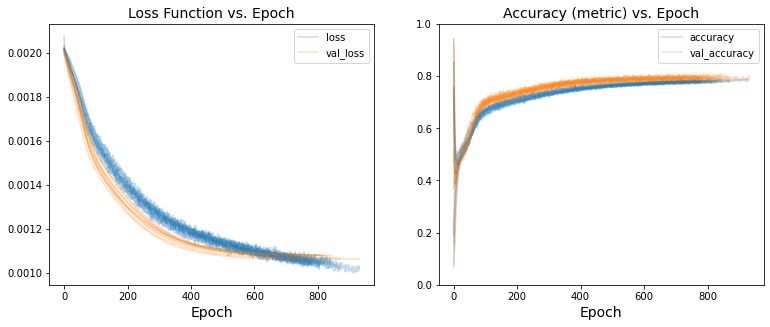

In [19]:
plt.figure(figsize=[2*6.4,1*4.8])

for i in range(n_models):
    
    this_NN = v_classifier[i]
    this_history = v_history[i]

    # Plot the significances with their error bars:
    ax = plt.subplot(1, 2, 1)
    # plt.figure()
    plt.title("Loss Function vs. Epoch", fontsize=14)
    plt.plot(this_history.history['loss'], alpha=0.25, color='C0')
    plt.plot(this_history.history['val_loss'], alpha=0.25, color='C1')
    plt.legend(['loss','val_loss'])
    plt.xlabel('Epoch', fontsize=14)
    # plt.ylabel('Loss', fontsize=14)
    
    # plt.yscale('log')

    ax = plt.subplot(1, 2, 2)
    # plt.figure()
    plt.title("Accuracy (metric) vs. Epoch", fontsize=14)
    plt.plot(this_history.history['accuracy'], alpha=0.25, color='C0')
    plt.plot(this_history.history['val_accuracy'], alpha=0.25, color='C1')
    plt.legend(['accuracy','val_accuracy'])
    plt.xlabel('Epoch', fontsize=14)
    plt.ylim([0,1])
    # plt.ylabel('Accuracy', fontsize=14)

plt.savefig('plots/loss_accuracy_{}.pdf'.format(name))
plt.show()

Add some variables

In [20]:
pred_columns = [c for c in x_test_results if c.startswith('pred')]
x_test_results['mean_pred'] = np.mean(x_test_results[pred_columns], axis=1)
x_test_results['is_signal'] = y_test
# Add the real weights back:
x_test_results['wgt'] = np.array(wgt_test)
x_test_results['SR'] = np.array(SR_test)
x_test_results['y'] = np.array(y_test)

x_train_results = x_train.copy()
x_train_results['pred'] = classifier.predict(x_train, batch_size=10000)
x_train_results['wgt'] = np.array(wgt_train) # wgt_train preserves the original weights, and shuffled
x_train_results['SR'] = np.array(SR_train)
x_train_results['y'] = np.array(y_train)

Plot yield vs NN output

# Normalized signal / background plot

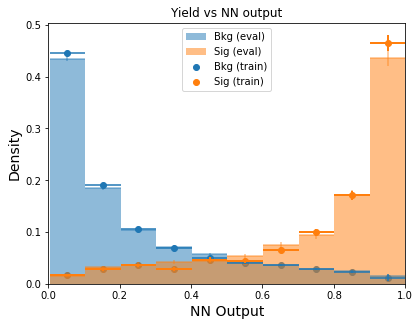

In [21]:
plt.figure(figsize=[1*6.4,1*4.8])

# BACKGROUND
# plt.subplot(1,2,1)
plt.title("Yield vs NN output")

n_bg_test = sum(wgt_test[y_test == 0])
n_bg_train = sum(wgt_train[y_train == 0])

n, b, _ = plt.hist(x_test_results[y_test == 0].mean_pred, bins=10, alpha=0.5, label='Bkg (eval)', 
                   weights = wgt_test[y_test == 0]/n_bg_test)
bin_centers = (b[:-1]+b[1:])/2
train_bg_bin_y = np.histogram(x_train_results[y_train == 0].pred, bins=b, 
                              weights = wgt_train[y_train == 0]/n_bg_train)[0]
scatter = plt.scatter(bin_centers, train_bg_bin_y, label='Bkg (train)')
# to plot error bars:
sumw2 = np.histogram(x_test_results[y_test == 0].mean_pred, bins=b, 
                              weights = (wgt_test[y_test == 0]/n_bg_test)**2)[0]
bin_widths  = (b[1:]-b[:-1])/2
plt.errorbar(x=bin_centers, y=n, xerr=bin_widths, yerr=np.sqrt(sumw2), fmt=' ', color='C0', alpha=0.5)
# to plot error bars:
sumw2 = np.histogram(x_train_results[y_train == 0].pred, bins=b, 
                              weights = (wgt_train[y_train == 0]/n_bg_train)**2)[0]
bin_widths  = (b[1:]-b[:-1])/2
plt.errorbar(x=bin_centers, y=scatter.get_offsets().data[:,1], xerr=bin_widths, yerr=np.sqrt(sumw2), fmt=' ', color='C0')


plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Yield', fontsize=14)
plt.xlim([0,1])
plt.legend()

# USING N(ENTRIES):
# ax = plt.subplot(1,2,2)
# plt.title("Signal Yield vs NN output")

n_sig_test = sum(wgt_test[y_test == 1])
n_sig_train = sum(wgt_train[y_train == 1])

n, b, _ = plt.hist(x_test_results[y_test == 1].mean_pred, bins=b, alpha=0.5, label='Sig (eval)', 
                   weights = wgt_test[y_test == 1]/n_sig_test, color='C1', linewidth=0)
bin_centers = (b[:-1]+b[1:])/2
train_sig_bin_y = np.histogram(x_train_results[y_train == 1].pred, bins=b, 
                              weights = wgt_train[y_train == 1]/n_sig_train)[0]
scatter = plt.scatter(bin_centers, train_sig_bin_y, label='Sig (train)', color='C1')
# to plot error bars:
sumw2 = np.histogram(x_test_results[y_test == 1].mean_pred, bins=b, 
                              weights = (wgt_test[y_test == 1]/n_sig_test)**2)[0]
bin_widths  = (b[1:]-b[:-1])/2
plt.errorbar(x=bin_centers, y=n, xerr=bin_widths, yerr=np.sqrt(sumw2), fmt=' ', color='C1', alpha=0.5)
# to plot error bars:
sumw2 = np.histogram(x_train_results[y_train == 1].pred, bins=b, 
                              weights = (wgt_train[y_train == 1]/n_sig_train)**2)[0]
plt.errorbar(x=bin_centers, y=scatter.get_offsets().data[:,1], xerr=bin_widths, yerr=np.sqrt(sumw2), 
             fmt=' ', color='C1', linewidth=2)

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim([0,1])
plt.legend()

# plt.yscale('log')

# plt.savefig('plots/plot1_together_{}.pdf'.format(name))
plt.savefig('plots/plot1_together_normalized_{}.pdf'.format(name))
# plt.savefig('plots/plot1_together_normalized_log_{}.pdf'.format(name))

# plt.savefig('plots/2021-12-11_batch_' + str(batch_size) + '.pdf')
plt.show()

In [22]:
print(sum(wgt_test[y_test == 0]))
print(sum(wgt_train[y_train == 0]))

print(sum(wgt_test[y_test == 1]))
print(sum(wgt_train[y_train == 1]))

155.57038948246714
155.88820655389432
2.7177862747212442
2.632539425064105


0.8808412027248114


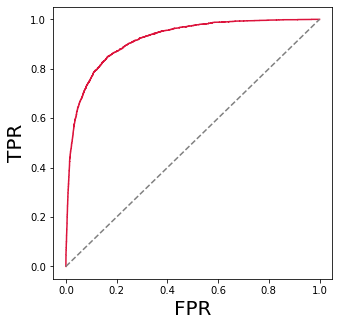

In [23]:
plt.figure(figsize=(5, 5))

# for c in ['pred_0', 'mean_pred']:
#     fpr, tpr, _ = roc_curve(y_test, x_test_results[c], sample_weight=w_test)

#     plt.plot(fpr, tpr)
    
for c in ['mean_pred']:
    fpr, tpr, _ = roc_curve(y_test, x_test_results[c], sample_weight=w_test)

    plt.plot(fpr, tpr, ls='-', color='crimson')
        
plt.plot([0, 1], [0, 1], ls='--', color='grey')
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.savefig('plots/ROC_{}.pdf'.format(name))

print(sum(tpr)/len(fpr))

plt.show()

# Finder of best cut in each signal region

In [38]:
print('Finding the best NN cut in each separate signal region:')
print()


best_significances = []
best_cuts = []

# for plotting:
list_cuts = [[],[],[]]
list_significances = [[],[],[]]
list_significance_errors = [[],[],[]]
list_signal_yields = [[],[],[]]
list_signal_yield_errors = [[],[],[]]
list_background_yields = [[],[],[]]
list_background_yield_errors = [[],[],[]]

for i in [0,1,2]:
    
    if (i==0): 
        print("---- In the region SF-inZ ----")
    if (i==1): 
        print("---- In the region SF-noZ ----")
    if (i==2): 
        print("---- In the region DF ----")
        
    best_cut = 0
    maximum_significance = 0
    maximum_significance_error = 0
    best_S = 0
    best_dS = 0
    best_B = 0
    best_dB = 0

    data_passed_cut = x_test_results[x_test_results.SR==i]

    for x in np.linspace(0,0.99,200):
        cut = x
        data_passed_cut = data_passed_cut[data_passed_cut.mean_pred >= cut]
        sig_passed_cut = data_passed_cut[data_passed_cut.is_signal == 1]
        bg_passed_cut = data_passed_cut[data_passed_cut.is_signal == 0]

        n_sig_passed_cut = sum(sig_passed_cut.wgt)
        n_bg_passed_cut = sum(bg_passed_cut.wgt)

        S, dS  = yield_and_error(sig_passed_cut)
        B, dB  = yield_and_error(bg_passed_cut)
            
        if (S<0):
            continue
        if (B<0):
            print(B)
            continue
#         if ((S+B)<(10/4)):
#             continue
        significance, error = significance_and_error(S, dS, B, dB)
        
        list_cuts[i].append(cut)
        list_significances[i].append(significance)
        list_significance_errors[i].append(error)
        list_signal_yields[i].append(S)
        list_signal_yield_errors[i].append(dS)
        list_background_yields[i].append(B)
        list_background_yield_errors[i].append(dB)
        
        if (cut == 0):
            print('Original yields:')
            print(' S: %.2f ± %.2f events'%(S,dS))
            print(' B: %.2f ± %.2f events'%(B,dB))
            print(' Significance = %.2f ± %.2f'%(significance, error))
            print()
            
        if ( (S+B) > 10/4):
            if (significance > maximum_significance):
                best_cut = cut
                maximum_significance = significance
                maximum_significance_error = error
                best_S = S
                best_dS = dS
                best_B = B
                best_dB = dB
            
    best_significances.append((maximum_significance, maximum_significance_error))
    best_cuts.append(best_cut)

    print('Best NN cut: %.3f'%(best_cut))
    print('New yields:')
    print(' S: %.2f ± %.2f events'%(best_S,best_dS))
    print(' B: %.2f ± %.2f events'%(best_B,best_dB))
    print(' Significance = %.2f ± %.2f'%(maximum_significance, maximum_significance_error))
    print("------------------------------")
    print()
    
    
print("---- In quadrature ----")


temporal = []

for i in [0,1,2]:
    maximum_significance = 0
    maximum_significance_error = 0
    best_S = 0
    best_dS = 0
    best_B = 0
    best_dB = 0

    data_passed_cut = x_test_results[x_test_results.SR==i]
    sig_passed_cut = data_passed_cut[data_passed_cut.is_signal == 1]
    bg_passed_cut = data_passed_cut[data_passed_cut.is_signal == 0]

    S, dS  = yield_and_error(sig_passed_cut)
    B, dB  = yield_and_error(bg_passed_cut)
    
    temporal.append((significance_and_error(S, dS, B, dB)))

old_quad, old_quad_error = add_in_quadrature_3(temporal[0], temporal[1], temporal[2]) 
print("Old significance = {:.2f} ± {:.2f} ".format(old_quad, old_quad_error))

best_quad, best_quad_error = add_in_quadrature_3(best_significances[0], best_significances[1], best_significances[2]) 
print("Best significance = {:.2f} ± {:.2f} ".format(best_quad, best_quad_error))

Finding the best NN cut in each separate signal region:

---- In the region SF-inZ ----
Original yields:
 S: 0.00 ± 0.00 events
 B: 0.00 ± 0.00 events
 Significance = 0.00 ± 0.00

Best NN cut: 0.000
New yields:
 S: 0.00 ± 0.00 events
 B: 0.00 ± 0.00 events
 Significance = 0.00 ± 0.00
------------------------------

---- In the region SF-noZ ----
Original yields:
 S: 2.72 ± 0.06 events
 B: 155.57 ± 1.22 events
 Significance = 0.22 ± 0.00

Best NN cut: 0.900
New yields:
 S: 1.18 ± 0.04 events
 B: 2.39 ± 0.17 events
 Significance = 0.71 ± 0.03
------------------------------

---- In the region DF ----
Original yields:
 S: 0.00 ± 0.00 events
 B: 0.00 ± 0.00 events
 Significance = 0.00 ± 0.00

Best NN cut: 0.000
New yields:
 S: 0.00 ± 0.00 events
 B: 0.00 ± 0.00 events
 Significance = 0.00 ± 0.00
------------------------------

---- In quadrature ----
Old significance = 0.22 ± 0.00 
Best significance = 0.71 ± 0.03 


# END

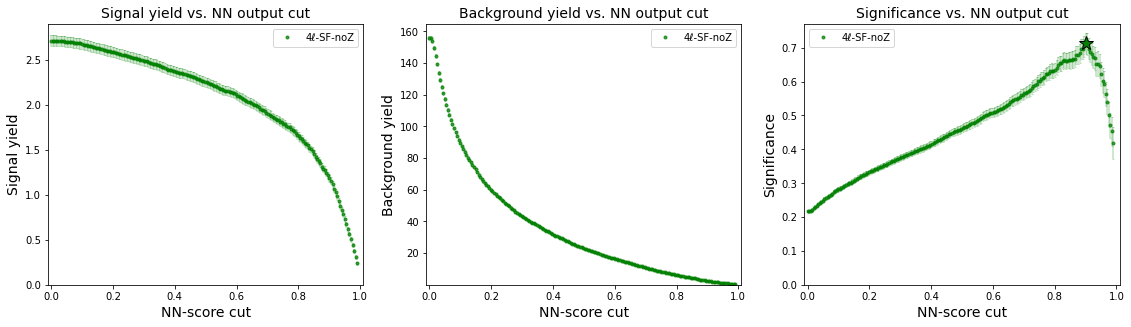

In [39]:
plt.figure(figsize=[3*6.4,1*4.8])

# Plot the significances with their error bars:
ax = plt.subplot(1, 3, 3)
# plt.figure(figsize=[1.5*6.4,1.5*4.8])
plt.title('Significance vs. NN output cut', fontsize=14)
plt.xlabel('NN-score cut', fontsize=14)
plt.ylabel('Significance', fontsize=14)
plt.errorbar(list_cuts[1], list_significances[1], yerr=list_significance_errors[1], 
             fmt=' ', capsize=1, color='green', alpha=0.25)
plt.plot(list_cuts[1],list_significances[1], 'o', markersize = 3, color='green', alpha=0.75)
plt.legend(['4ℓ-SF-noZ'])
# Plot the maximums:
plt.plot(best_cuts[1], best_significances[1][0],'*', color='green', fillstyle='full', 
         markeredgecolor='black', markersize=15)
plt.ylim(0)
plt.xlim([-0.01,1.01])
# plt.savefig('20211201.pdf')
# plt.show()

# Plot the signal yields with their error bars:
ax = plt.subplot(1, 3, 1)
# plt.figure(figsize=[1.5*6.4,1.5*4.8])
plt.title('Signal yield vs. NN output cut', fontsize=14)
plt.xlabel('NN-score cut', fontsize=14)
plt.ylabel('Signal yield', fontsize=14)
plt.errorbar(list_cuts[1], list_signal_yields[1], yerr=list_signal_yield_errors[1], 
             fmt=' ', capsize=1, color='green', alpha=0.25)
plt.plot(list_cuts[1],list_signal_yields[1], 'o', markersize = 3, color='green', alpha=0.75)
plt.ylim(0)
plt.xlim([-0.01,1.01])
plt.legend(['4ℓ-SF-noZ'])

# Plot the background yields with their error bars:
ax = plt.subplot(1, 3, 2)
# plt.figure(figsize=[1.5*6.4,1.5*4.8])
plt.title('Background yield vs. NN output cut', fontsize=14)
plt.xlabel('NN-score cut', fontsize=14)
plt.ylabel('Background yield', fontsize=14)
plt.errorbar(list_cuts[1], list_background_yields[1], yerr=list_background_yield_errors[1], 
             fmt=' ', capsize=1, color='green', alpha=0.25)
plt.plot(list_cuts[1],list_background_yields[1], 'o', markersize = 3, color='green', alpha=0.75)
plt.ylim(0.0001)
plt.xlim([-0.01,1.01])
# plt.yscale('log')
plt.legend(['4ℓ-SF-noZ'])

plt.savefig('plots/x_plot2_{}.pdf'.format(name))
plt.show()

## Plot weight distribution in some samples separated by physics process

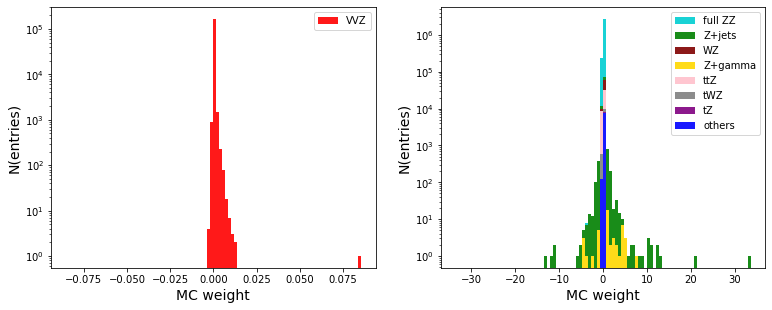

In [67]:
VVZ     = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_VVZ.arrow')
ZZ       = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_ZZ.arrow')
WZ       = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_WZ.arrow')
Zjets_new  = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_Zjets.arrow')
Zgamma = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_Zgamma.arrow')
ttZ    = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_ttZ.arrow')
tZ     = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_tZ.arrow')
tWZ    = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_tWZ.arrow')
others = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_others.arrow')
FULLBG = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_FULLBG.arrow')

# VVZ     = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_VVZ.arrow')
# ZZ       = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_ZZ.arrow')
# WZ       = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_WZ.arrow')
# Zjets_new  = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_Zjets.arrow')
# Zgamma = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_Zgamma.arrow')
# ttZ    = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_ttZ.arrow')
# tZ     = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_tZ.arrow')
# tWZ    = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_tWZ.arrow')
# others = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_others.arrow')
# FULLBG = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_FULLBG.arrow')


individual_backgrounds = [ZZ, WZ, Zjets_new, Zgamma, ttZ, tZ, tWZ, others]

order = [others, tZ, tWZ, ttZ, Zgamma, WZ, Zjets_new, ZZ]


plt.figure(figsize=[2*6.4,1*4.8])
variable, denom, my_range, my_bins = 'wgt', 1, (-30,30), 100
my_alpha = 0.9



ax = plt.subplot(1, 2, 1)
plt.xlabel('MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)
max_wgt = np.maximum( abs(np.min(VVZ['wgt'])), np.max(VVZ['wgt']) ) 
my_range = (-max_wgt,max_wgt)
n, bins, patches = plt.hist(VVZ[variable]/denom, range=my_range,
                            bins=my_bins, alpha=my_alpha, color='red', label='VVZ')
ax.legend(['VVZ'])
plt.yscale('log')
    

    
ax = plt.subplot(1, 2, 2)
plt.xlabel('MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)
colors = ('blue','purple','grey','pink', 'gold', 'maroon','green','darkturquoise')
labels = ('others', 'tZ', 'tWZ', 'ttZ', 'Z+gamma', 'WZ', 'Z+jets', 'full ZZ')
max_wgt = np.maximum( abs(np.min(FULLBG['wgt'])), np.max(FULLBG['wgt']) ) 
my_range = (-max_wgt,max_wgt)
n, bins, patches = plt.hist( (order[0][variable]/denom, 
                             order[1][variable]/denom,
                             order[2][variable]/denom,
                             order[3][variable]/denom,
                             order[4][variable]/denom,
                             order[5][variable]/denom,
                             order[6][variable]/denom,
                             order[7][variable]/denom),
                            range=my_range, 
                            bins=my_bins, alpha=my_alpha, 
                            color=colors, label=labels, stacked=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='best')
plt.yscale('log')

plt.savefig('plots/this.pdf')
plt.show()

In [46]:
max_wgt = np.maximum( abs(np.min(FULLBG['wgt'])), np.max(FULLBG['wgt']) )
max_wgt

33.633478207783135

In [47]:
abs(np.min(FULLBG['wgt']))

12.864305480738405

In [48]:
np.max(FULLBG['wgt'])

33.633478207783135

 end of notebook

# Test of Keras tuner

In [273]:
# Fit ML classifier
EPOCHS = 1000
batch_size = 1000
num_nodes = 64 # where is this used?
dropout = 0.1
# learning_rate = 

n_models = 1

x_test_results = x_test.copy()

def model_builder(hp):
    
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(28, 28)))

#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu'))
#     model.add(keras.layers.Dense(10))

#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])

#     return model

    classifier = Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=100, step=10)
    classifier.add(Dense(units=hp_units_1, input_dim=x_train.shape[1], activation='relu')) 
    classifier.add(Dropout(dropout))
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=100, step=10)
    classifier.add(Dense(units=hp_units_2, activation='relu'))
    classifier.add(Dropout(dropout))
    hp_units_3 = hp.Int('units_3', min_value=10, max_value=100, step=10)
    classifier.add(Dense(units=hp_units_3, activation='relu'))
    classifier.add(Dropout(dropout))
#     hp_units_4 = hp.Int('units_4', min_value=2, max_value=2, step=1)
#     classifier.add(Dense(units=hp_units_4, activation='relu'))
#     classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

#     history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
#                              validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
#                              verbose=1, callbacks=[callback])
    
#     x_test_results['pred_' + str(i)] = classifier.predict(x_test, batch_size=batch_size)
    return classifier

In [275]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt_0',
                    hyperband_iterations=1)

In [276]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [277]:
tuner.search(x_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
             validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
             verbose=1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units in dense layer 1 is {best_hps.get('units_1')}, 
The optimal number of units in dense layer 2 is {best_hps.get('units_2')},
The optimal number of units in dense layer 3 is {best_hps.get('units_3')}
""")

Trial 30 Complete [00h 00m 25s]
val_accuracy: 0.6669543385505676

Best val_accuracy So Far: 0.7773230075836182
Total elapsed time: 00h 05m 24s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in dense layer 1 is 100, 
The optimal number of units in dense layer 2 is 100,
The optimal number of units in dense layer 3 is 50



In [ ]:
model = tuner.hypermodel.build(best_hps)